# Analiza Trendów Czasowych z SHAP i ML Time Series - WESAD Dataset

Ten notebook:
1. **Używa tego samego pipeline** co `06_klasyfikacja_emocji_smote.ipynb` (wczytywanie, segmentacja, SMOTE)
2. **Identyfikuje najważniejsze cechy** używając **SHAP** (Shapley values)
3. **Trenuje model time series** (bez TensorFlow - używa sklearn)
4. **Porównuje z regresją** (Logistic Regression)
5. **Wykreśla trendy** najważniejszych cech w czasie

**Uwaga:** Wszystko wykonane bez TensorFlow, używając numpy, pandas, sklearn i SHAP.


## KROK 1: Import bibliotek


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GroupShuffleSplit

# Scipy dla sygnałów
try:
    from scipy.signal import resample
    from scipy import stats
    SCIPY_AVAILABLE = True
    print("✅ scipy dostępny")
except ImportError:
    SCIPY_AVAILABLE = False
    print("⚠️ scipy niedostępny - zainstaluj: pip install scipy")

# SHAP dla identyfikacji najważniejszych cech
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP dostępny")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP niedostępny - zainstaluj: pip install shap")

# SMOTE dla balansowania
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
    print("✅ imbalanced-learn (SMOTE) dostępny")
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("⚠️ imbalanced-learn niedostępny - zainstaluj: pip install imbalanced-learn")

print("✅ Biblioteki zaimportowane")


✅ scipy dostępny
✅ SHAP dostępny
✅ imbalanced-learn (SMOTE) dostępny
✅ Biblioteki zaimportowane


## KROK 2: WCZYTYWANIE DANYCH (z 06_klasyfikacja_emocji_smote.ipynb)


In [29]:
# ============================================================================
# KROK 2: WCZYTYWANIE DANYCH
# ============================================================================

# Ścieżki
RAW_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD")
PROJECT_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep")

# Parametry
TARGET_FS = 32.0
MAX_DURATION = pd.Timedelta(minutes=40)
DEFAULT_SUBJECTS = ["S2", "S3", "S4", "S5", "S6", "S7"]

# Mapowanie faz do klas (zgodnie z rzeczywistymi nazwami faz w WESAD)
PHASE_TO_CLASS = {
    "Base": "baseline",
    "Medi 1": "baseline",
    "Medi 2": "baseline",
    "TSST": "stress",
    "sRead": "stress",
    "fRead": "stress",
    "Fun": "amusement",
    # Alternatywne nazwy (na wypadek różnic w plikach)
    "Stress": "stress",
    "Amusement": "amusement",
    "Meditation": "baseline",
}

# Funkcje pomocnicze do parsowania
def build_time_index(length: int, start_ts: float, fs: float) -> pd.Series:
    """Buduje indeks czasowy dla sygnału"""
    start = pd.to_datetime(start_ts, unit="s", utc=True)
    offsets = pd.to_timedelta(np.arange(length) / fs, unit="s")
    return start + offsets

def load_sensor_for_subject(subject_path: Path, sensor_name: str) -> pd.DataFrame:
    """Wczytuje dane z sensora (CSV)"""
    file_path = subject_path / f"{sensor_name}.csv"
    if not file_path.exists():
        return pd.DataFrame()
    
    header = pd.read_csv(file_path, nrows=2, header=None)
    start_ts = float(header.iloc[0, 0])
    fs = float(header.iloc[1, 0])
    
    column_names = {
        "ACC": ["acc_x", "acc_y", "acc_z"],
        "EDA": ["eda"],
        "BVP": ["bvp"],
        "TEMP": ["temp"],
        "HR": ["hr"],
    }.get(sensor_name, [sensor_name.lower()])
    
    data = pd.read_csv(file_path, skiprows=2, header=None, names=column_names)
    data.insert(0, "timestamp", build_time_index(len(data), start_ts, fs))
    data.attrs.update({"start_ts": start_ts, "fs": fs})
    return data

def load_wesad_pickle(subject: str, raw_root: Path = RAW_ROOT) -> dict:
    """Wczytuje dane z pliku PKL"""
    pkl_path = raw_root / subject / f"{subject}.pkl"
    if not pkl_path.exists():
        raise FileNotFoundError(f"Brak pliku {pkl_path}")
    with pkl_path.open("rb") as handle:
        return pickle.load(handle, encoding="latin1")

def load_tags_for_subject(subject_path: Path) -> pd.DataFrame:
    """Wczytuje tagi (etykiety) dla subjecta"""
    path = subject_path / "tags.csv"
    if not path.exists() or path.stat().st_size == 0:
        return pd.DataFrame(columns=["timestamp", "tag"])
    tags = pd.read_csv(path, header=None, names=["timestamp"])
    tags["timestamp"] = pd.to_datetime(tags["timestamp"], unit="s", utc=True)
    tags["tag"] = 1
    return tags

def build_phase_protocol_for_subject(subject: str, session_start: pd.Timestamp, raw_root: Path = RAW_ROOT) -> pd.DataFrame:
    """Buduje protokół faz dla subjecta z pliku *_quest.csv"""
    quest_path = raw_root / subject / f"{subject}_quest.csv"
    if not quest_path.exists():
        return pd.DataFrame(columns=["phase", "start", "end", "duration_s"])
    
    lines = [line.strip() for line in quest_path.read_text().splitlines() if line.strip()]
    
    def _extract_values(lines, prefix):
        for line in lines:
            if line.startswith(prefix):
                return [token for token in line.split(";")[1:] if token]
        return []
    
    names = _extract_values(lines, "# ORDER")
    starts = _extract_values(lines, "# START")
    ends = _extract_values(lines, "# END")
    
    phases = []
    limit = min(len(names), len(starts), len(ends))
    for idx in range(limit):
        try:
            start_sec = float(starts[idx])
            end_sec = float(ends[idx])
            phase_name = names[idx].strip()
            phases.append({
                "phase": phase_name,
                "start": session_start + pd.to_timedelta(start_sec, unit="s"),
                "end": session_start + pd.to_timedelta(end_sec, unit="s"),
                "duration_s": end_sec - start_sec
            })
        except (ValueError, IndexError):
            continue
    
    return pd.DataFrame(phases)

def assign_phase_labels(timestamps: pd.Series, phases: pd.DataFrame) -> pd.Series:
    """Przypisuje etykiety faz do timestampów"""
    if phases.empty:
        return pd.Series(["unknown"] * len(timestamps), index=timestamps.index)
    intervals = pd.IntervalIndex.from_arrays(phases["start"], phases["end"], closed="left")
    labels = phases["phase"].to_list()
    idx = intervals.get_indexer(timestamps)
    label_array = np.array(labels, dtype=object)
    mapped = np.where(idx >= 0, label_array[idx], "unknown")
    return pd.Series(mapped, index=timestamps.index)

def resample_signal(array, src_fs: float, target_fs: float, target_len: int) -> np.ndarray:
    """Resampluje sygnał do docelowej częstotliwości"""
    if array.ndim == 1:
        array = array[:, None]
    expected_len = int(src_fs * MAX_DURATION.total_seconds())
    trimmed = array[:expected_len]
    if len(trimmed) == 0:
        return np.full((target_len, array.shape[1]), np.nan)
    return resample(trimmed, target_len, axis=0)

# Wczytanie danych dla wszystkich subjectów
print("=" * 80)
print("KROK 2: WCZYTYWANIE DANYCH")
print("=" * 80)

all_subjects_data = []

for subject in DEFAULT_SUBJECTS:
    print(f"\n📂 Wczytuję dane dla {subject}...")
    subject_path = RAW_ROOT / subject / f"{subject}_E4_Data"
    
    if not subject_path.exists():
        print(f"  ⚠️ Brak folderu {subject_path} - pomijam")
        continue
    
    # Wczytaj sygnały z nadgarstka (CSV)
    wrist_data = {}
    for sensor in ["ACC", "EDA", "BVP", "TEMP"]:
        sensor_df = load_sensor_for_subject(subject_path, sensor)
        if not sensor_df.empty:
            wrist_data[sensor.lower()] = sensor_df
    
    # Sprawdź czy mamy dane
    if not wrist_data:
        print(f"  ⚠️ Brak danych z nadgarstka - pomijam")
        continue
    
    # Użyj timestamp z pierwszego sensora jako session_start
    first_sensor = list(wrist_data.values())[0]
    if len(first_sensor) == 0:
        print(f"  ⚠️ Pusty sensor - pomijam")
        continue
    
    session_start = first_sensor["timestamp"].iloc[0]
    
    # Wczytaj protokół faz
    phases = build_phase_protocol_for_subject(subject, session_start)
    
    # Połącz dane nadgarstka
    if wrist_data:
        # Użyj BVP jako referencji czasowej
        if "bvp" in wrist_data:
            base_df = wrist_data["bvp"][["timestamp"]].copy()
            for sensor_name, sensor_df in wrist_data.items():
                if sensor_name != "bvp":
                    # Resample do częstotliwości BVP
                    merged = pd.merge_asof(
                        base_df.sort_values("timestamp"),
                        sensor_df[["timestamp"] + [col for col in sensor_df.columns if col != "timestamp"]].sort_values("timestamp"),
                        on="timestamp",
                        direction="nearest",
                        tolerance=pd.Timedelta(seconds=1)
                    )
                    for col in sensor_df.columns:
                        if col != "timestamp":
                            base_df[col] = merged[col].values
            
            # Dodaj pozostałe kolumny z BVP
            for col in wrist_data["bvp"].columns:
                if col != "timestamp" and col not in base_df.columns:
                    base_df[col] = wrist_data["bvp"][col].values
            
            # Resample do docelowej częstotliwości
            target_len = int(MAX_DURATION.total_seconds() * TARGET_FS)
            timestamps = session_start + pd.to_timedelta(np.arange(target_len) / TARGET_FS, unit="s")
            
            # Resample każdej kolumny
            resampled_data = {}
            for col in base_df.columns:
                if col != "timestamp":
                    original_values = base_df[col].values
                    if len(original_values) > 0:
                        resampled = resample_signal(original_values, wrist_data["bvp"].attrs["fs"], TARGET_FS, target_len)
                        resampled_data[col] = resampled.flatten() if resampled.ndim > 1 else resampled
                    else:
                        resampled_data[col] = np.full(target_len, np.nan)
            
            # Stwórz DataFrame
            subject_df = pd.DataFrame(resampled_data)
            subject_df.insert(0, "timestamp", timestamps)
            
            # Dodaj etykiety faz
            subject_df["phase"] = assign_phase_labels(subject_df["timestamp"], phases)
            subject_df["label"] = subject_df["phase"].map(PHASE_TO_CLASS).fillna("unknown")
            subject_df["subject"] = subject
            
            # Sprawdź rozkład faz i klas dla tego subjecta
            phase_dist = subject_df["phase"].value_counts()
            label_dist = subject_df["label"].value_counts()
            print(f"    Fazy: {dict(phase_dist)}")
            print(f"    Klasy: {dict(label_dist)}")
            
            all_subjects_data.append(subject_df)
            print(f"  ✅ Wczytano {len(subject_df)} próbek")

# Połącz wszystkie dane
if all_subjects_data:
    full_data = pd.concat(all_subjects_data, ignore_index=True)
    print(f"\n{'='*80}")
    print("PODSUMOWANIE WCZYTYWANIA DANYCH")
    print(f"{'='*80}")
    print(f"✅ Wczytano dane dla {len(all_subjects_data)} subjectów")
    print(f"   Łączna liczba próbek: {len(full_data)}")
    
    print(f"\n📊 SZCZEGÓŁOWY ROZKŁAD KLAS PER SUBJECT:")
    print("-" * 80)
    for subject in full_data["subject"].unique():
        subject_data = full_data[full_data["subject"] == subject]
        print(f"\n  {subject}:")
        label_dist = subject_data["label"].value_counts()
        for label in label_dist.index:
            count = label_dist[label]
            pct = (count / len(subject_data) * 100) if len(subject_data) > 0 else 0
            print(f"    {label:12s}: {count:6d} próbek ({pct:6.2f}%)")
    
    print(f"\n📊 GLOBALNY ROZKŁAD KLAS (wszystkie subjecty):")
    print("-" * 80)
    class_dist = full_data["label"].value_counts()
    for label in class_dist.index:
        count = class_dist[label]
        pct = (count / len(full_data) * 100) if len(full_data) > 0 else 0
        print(f"   {label:12s}: {count:6d} próbek ({pct:6.2f}%)")
    
    print(f"\n✅ WCZYTYWANIE DANYCH ZAKOŃCZONE POMYŚLNIE!")
else:
    print("❌ Nie wczytano żadnych danych!")
    raise ValueError("Brak danych do analizy")


KROK 2: WCZYTYWANIE DANYCH

📂 Wczytuję dane dla S2...
    Fazy: {'unknown': 75098, 'Base': 616, 'TSST': 344, 'Medi 1': 221, 'Medi 2': 216, 'Fun': 200, 'sRead': 53, 'fRead': 52}
    Klasy: {'unknown': 75098, 'baseline': 1053, 'stress': 449, 'amusement': 200}
  ✅ Wczytano 76800 próbek

📂 Wczytuję dane dla S3...
    Fazy: {'unknown': 75040, 'Base': 627, 'TSST': 352, 'Medi 1': 225, 'Medi 2': 217, 'Fun': 203, 'bRead': 55, 'fRead': 41, 'sRead': 40}
    Klasy: {'unknown': 75095, 'baseline': 1069, 'stress': 433, 'amusement': 203}
  ✅ Wczytano 76800 próbek

📂 Wczytuję dane dla S4...
    Fazy: {'unknown': 75009, 'Base': 633, 'TSST': 350, 'Medi 1': 239, 'Medi 2': 223, 'Fun': 215, 'fRead': 49, 'bRead': 48, 'sRead': 34}
    Klasy: {'unknown': 75057, 'baseline': 1095, 'stress': 433, 'amusement': 215}
  ✅ Wczytano 76800 próbek

📂 Wczytuję dane dla S5...
    Fazy: {'unknown': 75032, 'Base': 646, 'TSST': 354, 'Medi 1': 223, 'Medi 2': 223, 'Fun': 203, 'bRead': 43, 'fRead': 42, 'sRead': 34}
    Klasy: {'

In [30]:
# Ta komórka została zastąpiona - dane są wczytywane w komórce 4 (KROK 2)
# Sprawdź czy full_data jest dostępne
if 'full_data' in globals():
    print(f"✅ Dane są już wczytane w komórce 4 (KROK 2)")
    print(f"   Liczba subjectów: {len(full_data['subject'].unique())}")
    print(f"   Łączna liczba próbek: {len(full_data)}")
else:
    print("⚠️ Uruchom najpierw komórkę 4 (KROK 2: WCZYTYWANIE DANYCH)")


✅ Dane są już wczytane w komórce 4 (KROK 2)
   Liczba subjectów: 6
   Łączna liczba próbek: 460800


## KROK 3: SEGMENTACJA DANYCH (SLIDING WINDOWS)

Tworzymy okna czasowe i wyciągamy statystyczne cechy z każdego okna.


In [31]:
# ============================================================================
# KROK 3: SEGMENTACJA DANYCH (SLIDING WINDOWS)
# ============================================================================

# Sprawdź dostępność zmiennych
if 'full_data' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 2!")
    raise NameError("full_data nie jest zdefiniowane - uruchom najpierw KROK 2")

# Parametry segmentacji
WINDOW_SIZE_SECONDS = 5  # Rozmiar okna w sekundach
STEP_SIZE_SECONDS = 2.5  # Krok (50% overlap)
WINDOW_SIZE = int(WINDOW_SIZE_SECONDS * TARGET_FS)  # Rozmiar okna w próbkach
STEP_SIZE = int(STEP_SIZE_SECONDS * TARGET_FS)  # Krok w próbkach

print("=" * 80)
print("KROK 3: SEGMENTACJA DANYCH (SLIDING WINDOWS)")
print("=" * 80)
print(f"  Rozmiar okna: {WINDOW_SIZE_SECONDS} sekund ({WINDOW_SIZE} próbek)")
print(f"  Krok: {STEP_SIZE_SECONDS} sekund ({STEP_SIZE} próbek)")
print(f"  Overlap: {(1 - STEP_SIZE_SECONDS/WINDOW_SIZE_SECONDS)*100:.1f}%")

# Funkcje do ekstrakcji cech
def compute_rms(signal):
    """Oblicza RMS (Root Mean Square)"""
    return np.sqrt(np.mean(signal**2))

def compute_kurtosis(signal):
    """Oblicza kurtozę"""
    if len(signal) < 4:
        return 0.0
    return stats.kurtosis(signal, nan_policy='omit')

def compute_skewness(signal):
    """Oblicza skośność"""
    if len(signal) < 3:
        return 0.0
    return stats.skew(signal, nan_policy='omit')

def compute_rmssd(signal):
    """Oblicza RMSSD (Root Mean Square of Successive Differences) - dla HRV"""
    if len(signal) < 2:
        return 0.0
    diff = np.diff(signal)
    return np.sqrt(np.mean(diff**2))

def compute_slope(signal):
    """Oblicza nachylenie (slope) - trend liniowy"""
    if len(signal) < 2:
        return 0.0
    x = np.arange(len(signal))
    coeffs = np.polyfit(x, signal, 1)
    return coeffs[0]

def compute_respiration_rate(signal, fs=TARGET_FS):
    """Oblicza tempo oddechu (dla sygnału respiracji)"""
    if len(signal) < int(fs * 2):  # Minimum 2 sekundy
        return 0.0
    # Znajdź peaki (uproszczone)
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(signal, distance=int(fs * 0.5))  # Minimum 0.5s między peakami
    if len(peaks) < 2:
        return 0.0
    # Oblicz średni czas między peakami
    peak_intervals = np.diff(peaks) / fs
    avg_interval = np.mean(peak_intervals)
    if avg_interval > 0:
        return 60.0 / avg_interval  # Oddechy na minutę
    return 0.0

def extract_features_from_window(window_data):
    """Wyciąga cechy statystyczne z okna"""
    features = {}
    
    # Kolumny sygnałów (pomijamy timestamp, phase, label, subject)
    signal_cols = [col for col in window_data.columns 
                   if col not in ["timestamp", "phase", "label", "subject"]]
    
    for col in signal_cols:
        signal = window_data[col].values
        signal_clean = signal[~np.isnan(signal)]
        
        if len(signal_clean) == 0:
            # Jeśli wszystkie wartości są NaN, ustaw wszystkie cechy na 0
            features[f"{col}_mean"] = 0.0
            features[f"{col}_std"] = 0.0
            features[f"{col}_min"] = 0.0
            features[f"{col}_max"] = 0.0
            features[f"{col}_range"] = 0.0
            features[f"{col}_rms"] = 0.0
            features[f"{col}_kurtosis"] = 0.0
            features[f"{col}_skewness"] = 0.0
            features[f"{col}_rmssd"] = 0.0
            features[f"{col}_slope"] = 0.0
            continue
        
        # Podstawowe statystyki
        features[f"{col}_mean"] = np.mean(signal_clean)
        features[f"{col}_std"] = np.std(signal_clean) if len(signal_clean) > 1 else 0.0
        features[f"{col}_min"] = np.min(signal_clean)
        features[f"{col}_max"] = np.max(signal_clean)
        features[f"{col}_range"] = features[f"{col}_max"] - features[f"{col}_min"]
        
        # Zaawansowane cechy
        features[f"{col}_rms"] = compute_rms(signal_clean)
        features[f"{col}_kurtosis"] = compute_kurtosis(signal_clean)
        features[f"{col}_skewness"] = compute_skewness(signal_clean)
        features[f"{col}_rmssd"] = compute_rmssd(signal_clean)
        features[f"{col}_slope"] = compute_slope(signal_clean)
        
        # Tempo oddechu (tylko dla kolumn związanych z oddechem)
        if "resp" in col.lower() or "breath" in col.lower():
            features[f"{col}_respiration_rate"] = compute_respiration_rate(signal_clean)
    
    return features

# Segmentacja sliding window
print(f"\n🔧 Wykonuję segmentację sliding window...")

segmented_data = []
groups = []  # Dla subject-wise split

for subject in full_data["subject"].unique():
    subject_data = full_data[full_data["subject"] == subject].copy()
    subject_data = subject_data.sort_values("timestamp").reset_index(drop=True)
    
    # Segmentacja
    n_samples = len(subject_data)
    for start_idx in range(0, n_samples - WINDOW_SIZE + 1, STEP_SIZE):
        end_idx = start_idx + WINDOW_SIZE
        window = subject_data.iloc[start_idx:end_idx].copy()
        
        # Wyciągnij cechy
        features = extract_features_from_window(window)
        
        # Etykieta okna (mode z okna)
        label_counts = window["label"].value_counts()
        window_label = label_counts.index[0] if len(label_counts) > 0 else "unknown"
        
        # Dodaj metadane
        features["label"] = window_label
        features["subject"] = subject
        features["window_start"] = start_idx
        features["window_end"] = end_idx
        
        segmented_data.append(features)
        groups.append(subject)

# Stwórz DataFrame z segmentowanych danych
segmented_df = pd.DataFrame(segmented_data)

print(f"\n{'='*80}")
print("PODSUMOWANIE SEGMENTACJI")
print(f"{'='*80}")
print(f"✅ Segmentacja zakończona!")
print(f"   Liczba okien: {len(segmented_df)}")
print(f"   Liczba cech: {len([col for col in segmented_df.columns if col not in ['label', 'subject', 'window_start', 'window_end']])}")

# Sprawdź rozkład klas przed usunięciem "unknown"
print(f"\n📊 ROZKŁAD KLAS PRZED USUNIĘCIEM 'unknown':")
print("-" * 80)
class_dist_before_clean = segmented_df["label"].value_counts()
for label in class_dist_before_clean.index:
    count = class_dist_before_clean[label]
    pct = (count / len(segmented_df) * 100) if len(segmented_df) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Usuń okna z etykietą "unknown"
segmented_df = segmented_df[segmented_df["label"] != "unknown"].copy()
print(f"\n📊 Liczba okien po usunięciu 'unknown': {len(segmented_df)}")
print(f"   Usunięto: {len(segmented_data) - len(segmented_df)} okien z etykietą 'unknown'")

# Sprawdź rozkład klas przed agregacją
print(f"\n📊 Rozkład klas PRZED agregacją:")
class_dist_before_agg = segmented_df["label"].value_counts()
print(class_dist_before_agg)

# ⚠️ WAŻNE: Agregacja klas (amusement + stress → emotion)
print(f"\n{'='*80}")
print("AGREGACJA KLAS: amusement + stress → emotion")
print(f"{'='*80}")
segmented_df["label"] = segmented_df["label"].replace({
    "amusement": "emotion",
    "stress": "emotion"
})
print(f"   ✅ Agregacja wykonana: amusement + stress → emotion")

# Użyj kolumny 'subject' z segmented_df jako groups (najprostsze i najbardziej niezawodne)
if 'subject' in segmented_df.columns:
    groups = segmented_df['subject'].tolist()
    print(f"   ✅ Utworzono groups z kolumny 'subject': {len(groups)} elementów")
else:
    print(f"   ⚠️ OSTRZEŻENIE: Brak kolumny 'subject' w segmented_df!")
    raise ValueError("Brak kolumny 'subject' w segmented_df - nie można utworzyć groups")

# Sprawdź rozkład klas po agregacji
print(f"\n📊 ROZKŁAD KLAS PO AGREGACJI:")
print("-" * 80)
class_dist_seg = segmented_df["label"].value_counts()
for label in class_dist_seg.index:
    count = class_dist_seg[label]
    pct = (count / len(segmented_df) * 100) if len(segmented_df) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Sprawdź rozkład klas per subject po agregacji
print(f"\n📊 ROZKŁAD KLAS PER SUBJECT PO AGREGACJI:")
print("-" * 80)
for subject in segmented_df["subject"].unique():
    subject_data = segmented_df[segmented_df["subject"] == subject]
    print(f"\n  {subject}:")
    label_dist = subject_data["label"].value_counts()
    for label in label_dist.index:
        count = label_dist[label]
        pct = (count / len(subject_data) * 100) if len(subject_data) > 0 else 0
        print(f"    {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Weryfikacja: czy mamy obie klasy (baseline i emotion)
unique_labels = segmented_df["label"].unique()
print(f"\n{'='*80}")
print("WERYFIKACJA KLAS PO SEGMENTACJI I AGREGACJI")
print(f"{'='*80}")
print(f"   Unikalne klasy: {unique_labels}")
print(f"   Liczba klas: {len(unique_labels)}")

if len(unique_labels) < 2:
    print(f"\n❌❌❌ BŁĄD: Tylko {len(unique_labels)} klas po segmentacji!")
    print(f"   Musimy mieć co najmniej 2 klasy (baseline i emotion) dla SMOTE!")
    print(f"   Sprawdź wczytywanie faz i mapowanie PHASE_TO_CLASS.")
    print(f"\n📊 DIAGNOSTYKA:")
    print(f"   - Sprawdź czy fazy są poprawnie wczytywane z plików *_quest.csv")
    print(f"   - Sprawdź czy mapowanie PHASE_TO_CLASS jest poprawne")
    print(f"   - Sprawdź czy assign_phase_labels działa poprawnie")
else:
    print(f"   ✅ Mamy {len(unique_labels)} klas - OK dla SMOTE")
    print(f"   ✅ Klasy: {', '.join(unique_labels)}")
    
    # Sprawdź balance ratio przed SMOTE
    if len(unique_labels) == 2:
        counts = [class_dist_seg[label] for label in unique_labels]
        balance_ratio = min(counts) / max(counts) if max(counts) > 0 else 0
        print(f"   📊 Balance ratio (przed SMOTE): {balance_ratio:.4f}")
        if balance_ratio < 0.5:
            print(f"   ⚠️ OSTRZEŻENIE: Silna nierównowaga klas (balance ratio < 0.5)")
            print(f"      SMOTE będzie musiał wygenerować dużo syntetycznych próbek")


KROK 3: SEGMENTACJA DANYCH (SLIDING WINDOWS)
  Rozmiar okna: 5 sekund (160 próbek)
  Krok: 2.5 sekund (80 próbek)
  Overlap: 50.0%

🔧 Wykonuję segmentację sliding window...


KeyboardInterrupt: 

## KROK 4: ENCODING I SKALOWANIE CECH

Kodujemy etykiety i skalujemy cechy.


In [ ]:
# ============================================================================
# KROK 4: ENCODING I SKALOWANIE CECH
# ============================================================================

# Sprawdź dostępność zmiennych
if 'segmented_df' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 3!")
    raise NameError("segmented_df nie jest zdefiniowane - uruchom najpierw KROK 3")

print("=" * 80)
print("KROK 4: ENCODING I SKALOWANIE CECH")
print("=" * 80)

# Przygotuj dane
feature_cols = [col for col in segmented_df.columns 
                if col not in ["label", "subject", "window_start", "window_end"]]
X = segmented_df[feature_cols].copy()
y = segmented_df["label"].copy()

# Usuń kolumny z samymi NaN
X = X.dropna(axis=1, how='all')

# Wypełnij pozostałe NaN zerami
X = X.fillna(0.0)

print(f"\n📊 Kształt danych:")
print(f"   X: {X.shape}")
print(f"   y: {len(y)} próbek")

# LabelEncoder dla targetu
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n✅ LabelEncoder:")
print(f"   Klasy: {label_encoder.classes_}")
print(f"   Kodowanie: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# StandardScaler dla cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"\n✅ StandardScaler:")
print(f"   Cechy przeskalowane: {X_scaled.shape[1]}")
print(f"   Przykładowe wartości (pierwsze 5 cech, pierwsze 3 próbki):")
print(X_scaled.iloc[:3, :5])


KROK 4: ENCODING I SKALOWANIE CECH

📊 Kształt danych:
   X: (123, 60)
   y: 123 próbek

✅ LabelEncoder:
   Klasy: ['baseline' 'emotion']
   Kodowanie: {'baseline': 0, 'emotion': 1}

✅ StandardScaler:
   Cechy przeskalowane: 60
   Przykładowe wartości (pierwsze 5 cech, pierwsze 3 próbki):
   acc_x_mean  acc_x_std  acc_x_min  acc_x_max  acc_x_range
2    0.746109  -0.743730   1.082446   0.096562    -0.773286
3    0.752501  -0.765521   1.087307   0.096423    -0.777279
4    0.746653  -0.778669   1.101748   0.095018    -0.790038


## KROK 5: PODZIAŁ TRAIN/TEST - SUBJECT-WISE SPLIT

⚠️ **WAŻNE**: Całe dane jednej osoby trafiają albo do train, albo do test. Nie dzielimy okien z tej samej osoby między train i test.


In [ ]:
# ============================================================================
# KROK 5: PODZIAŁ TRAIN/TEST - SUBJECT-WISE SPLIT
# ============================================================================

# Sprawdź dostępność zmiennych
if 'X_scaled' not in globals() or 'y_encoded' not in globals() or 'groups' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 3 i KROK 4!")
    raise NameError("X_scaled, y_encoded lub groups nie są zdefiniowane - uruchom najpierw KROK 3 i KROK 4")

print("=" * 80)
print("KROK 5: PODZIAŁ TRAIN/TEST - SUBJECT-WISE SPLIT")
print("=" * 80)
print("⚠️ WAŻNE: Całe dane jednej osoby trafiają albo do train, albo do test")
print("⚠️ WAŻNE: Nie dzielimy okien z tej samej osoby między train i test")

# Sprawdź długości i konwertuj groups na numpy array
print(f"\n📊 Weryfikacja danych przed split:")
print(f"   X_scaled shape: {X_scaled.shape}")
print(f"   y_encoded length: {len(y_encoded)}")
print(f"   groups length: {len(groups)}")

if len(groups) != len(X_scaled) or len(groups) != len(y_encoded):
    print(f"\n❌❌❌ BŁĄD: Długości się nie zgadzają!")
    print(f"   X_scaled: {len(X_scaled)}, y_encoded: {len(y_encoded)}, groups: {len(groups)}")
    raise ValueError("Długości X_scaled, y_encoded i groups muszą być identyczne!")

# Konwertuj groups na numpy array (wymagane przez GroupShuffleSplit)
groups_array = np.array(groups)
print(f"   ✅ groups skonwertowany na numpy array: {groups_array.shape}")

# Użyj GroupShuffleSplit z wieloma próbami, aby znaleźć podział z obiema klasami w train i test
gss = GroupShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

best_train_idx = None
best_test_idx = None
best_score = -np.inf
best_train_subjects = None
best_test_subjects = None

print(f"\n🔍 Szukam najlepszego podziału (testuję {gss.n_splits} różnych podziałów)...")

for train_idx, test_idx in gss.split(X_scaled, y_encoded, groups=groups_array):
    # Sprawdź czy w train i test są obecne obie klasy
    train_classes = np.unique(y_encoded[train_idx])
    test_classes = np.unique(y_encoded[test_idx])
    
    # Wszystkie klasy muszą być w train (wymagane dla SMOTE)
    if len(train_classes) >= 2:
        # Sprawdź subjecty w train i test
        train_subjects_set = set(groups_array[train_idx])
        test_subjects_set = set(groups_array[test_idx])
        
        # Oblicz "score" - preferuj podziały z obiema klasami w test i więcej subjectów
        score = len(train_classes) * 10 + len(test_classes) * 5 + len(train_subjects_set) + len(test_subjects_set)
        if score > best_score:
            best_score = score
            best_train_idx = train_idx
            best_test_idx = test_idx
            best_train_subjects = train_subjects_set
            best_test_subjects = test_subjects_set

# Jeśli nie znaleziono podziału z obiema klasami w train, rzuć błąd
if best_train_idx is None:
    print(f"\n❌❌❌ BŁĄD: Nie znaleziono podziału z co najmniej 2 klasami w train!")
    raise ValueError("Nie można utworzyć podziału z co najmniej 2 klasami w train - SMOTE nie będzie działać!")

train_idx = best_train_idx
test_idx = best_test_idx

print(f"\n✅ Znaleziono najlepszy podział:")
print(f"   Score: {best_score}")
print(f"   Train subjects: {sorted(best_train_subjects)} ({len(best_train_subjects)} subjectów)")
print(f"   Test subjects: {sorted(best_test_subjects)} ({len(best_test_subjects)} subjectów)")

X_train = X_scaled.iloc[train_idx].copy()
X_test = X_scaled.iloc[test_idx].copy()
y_train = y_encoded[train_idx]
y_test = y_encoded[test_idx]
groups_train = [groups[i] for i in train_idx]
groups_test = [groups[i] for i in test_idx]

# Sprawdź które subjecty trafiły do train/test
train_subjects = set(groups_train)
test_subjects = set(groups_test)

print(f"\n✅ Podział subject-wise:")
print(f"   Train subjects: {sorted(train_subjects)} ({len(train_subjects)} subjectów)")
print(f"   Test subjects: {sorted(test_subjects)} ({len(test_subjects)} subjectów)")

# Weryfikacja: train i test subjects są rozłączne
if train_subjects & test_subjects:
    print(f"\n❌❌❌ BŁĄD: Train i test subjects się nakładają!")
    raise ValueError("Subject-wise split nie działa poprawnie!")
else:
    print(f"   ✅ Train i test subjects są rozłączne - OK")

# Sprawdź rozkład klas w train i test
print(f"\n📊 Rozkład klas w TRAIN:")
train_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
for label in train_dist.index:
    count = train_dist[label]
    pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

print(f"\n📊 Rozkład klas w TEST:")
test_dist = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
for label in test_dist.index:
    count = test_dist[label]
    pct = (count / len(y_test) * 100) if len(y_test) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Weryfikacja: czy w train są co najmniej 2 klasy (wymagane dla SMOTE)
train_unique_classes = np.unique(y_train)
test_unique_classes = np.unique(y_test)

print(f"\n✅ WERYFIKACJA KLAS:")
print(f"   Train: {len(train_unique_classes)} klas - {label_encoder.inverse_transform(train_unique_classes)}")
print(f"   Test: {len(test_unique_classes)} klas - {label_encoder.inverse_transform(test_unique_classes)}")

if len(train_unique_classes) < 2:
    print(f"\n⚠️ OSTRZEŻENIE: Tylko {len(train_unique_classes)} klas w train!")
    print(f"   SMOTE wymaga co najmniej 2 klas. Balansowanie może nie działać.")
else:
    print(f"   ✅ Train ma co najmniej 2 klasy - SMOTE może działać")

print(f"\n✅ Podział zakończony:")
print(f"   Train: {len(X_train)} próbek")
print(f"   Test: {len(X_test)} próbek")


KROK 5: PODZIAŁ TRAIN/TEST - SUBJECT-WISE SPLIT
⚠️ WAŻNE: Całe dane jednej osoby trafiają albo do train, albo do test
⚠️ WAŻNE: Nie dzielimy okien z tej samej osoby między train i test

📊 Weryfikacja danych przed split:
   X_scaled shape: (123, 60)
   y_encoded length: 123
   groups length: 123
   ✅ groups skonwertowany na numpy array: (123,)

🔍 Szukam najlepszego podziału (testuję 100 różnych podziałów)...

✅ Znaleziono najlepszy podział:
   Score: 36
   Train subjects: ['S4', 'S5', 'S6', 'S7'] (4 subjectów)
   Test subjects: ['S2', 'S3'] (2 subjectów)

✅ Podział subject-wise:
   Train subjects: ['S4', 'S5', 'S6', 'S7'] (4 subjectów)
   Test subjects: ['S2', 'S3'] (2 subjectów)
   ✅ Train i test subjects są rozłączne - OK

📊 Rozkład klas w TRAIN:
   baseline    :   54 próbek ( 65.9%)
   emotion     :   28 próbek ( 34.1%)

📊 Rozkład klas w TEST:
   baseline    :   26 próbek ( 63.4%)
   emotion     :   15 próbek ( 36.6%)

✅ WERYFIKACJA KLAS:
   Train: 2 klas - ['baseline' 'emotion']
   

In [ ]:
## KROK 6: BALANSOWANIE DANYCH W TRENINGU (SMOTE)

**WAZNE**: SMOTE TYLKO na train, test pozostaje niezmieniony!
    if feat not in feature_to_signal:
        print(f"   ⚠️ {feat} nie ma mapowania na sygnał")
        continue
    
    signal_name, feature_type = feature_to_signal[feat]
    print(f"\n   📊 Przetwarzam {feat} (sygnał: {signal_name}, cecha: {feature_type})...")
    
    # Zbierz wszystkie wartości tej cechy dla baseline i emotion
    baseline_windows = []
    emotion_windows = []
    
    samples_processed = 0
    samples_with_signal = 0
    
    for sample in all_data:
        samples_processed += 1
        if signal_name not in sample:
            continue
        
        sig = np.array(sample[signal_name])
        if len(sig) == 0:
            continue
        
        samples_with_signal += 1
        
        # Sprawdź czy sygnał ma wystarczającą długość
        if len(sig) < window_size:
            continue
        
        # Podziel sygnał na okna i oblicz cechę dla każdego okna
        window_values = []
        for i in range(0, len(sig) - window_size + 1, stride):
            window = sig[i:i + window_size]
            if len(window) == window_size:
                window_clean = window[~np.isnan(window)]
                if len(window_clean) > 0:
                    # Oblicz cechę dla tego okna
                    if feature_type == 'mean':
                        window_val = np.mean(window_clean)
                    elif feature_type == 'std':
                        window_val = np.std(window_clean)
                    elif feature_type == 'rms':
                        window_val = np.sqrt(np.mean(window_clean**2))
                    elif feature_type == 'range':
                        window_val = np.max(window_clean) - np.min(window_clean)
                    elif feature_type == 'median':
                        window_val = np.median(window_clean)
                    else:
                        window_val = np.mean(window_clean)
                    
                    if not np.isnan(window_val):
                        window_values.append(window_val)
        
        # Dodaj do odpowiedniej klasy
        if sample['class'] == 'baseline' and len(window_values) > 0:
            baseline_windows.append(window_values)
        elif sample['class'] == 'emotion' and len(window_values) > 0:
            emotion_windows.append(window_values)
    
    print(f"      Przetworzono {samples_with_signal}/{samples_processed} próbek z sygnałem {signal_name}")
    print(f"      Baseline windows: {len(baseline_windows)}, Emotion windows: {len(emotion_windows)}")
    
    # Uśrednij po wszystkich próbkach dla każdego okna czasowego
    # Działa nawet jeśli jest tylko jedna klasa
    if len(baseline_windows) > 0:
        min_len_baseline = min([len(w) for w in baseline_windows]) if baseline_windows else 0
        if min_len_baseline > 0:
            baseline_avg = np.mean([w[:min_len_baseline] for w in baseline_windows if len(w) >= min_len_baseline], axis=0)
            trend_dict[f'{feat}_baseline'] = baseline_avg
            print(f"   ✅ {feat}_baseline: {len(baseline_avg)} okien")
    
    if len(emotion_windows) > 0:
        min_len_emotion = min([len(w) for w in emotion_windows]) if emotion_windows else 0
        if min_len_emotion > 0:
            emotion_avg = np.mean([w[:min_len_emotion] for w in emotion_windows if len(w) >= min_len_emotion], axis=0)
            trend_dict[f'{feat}_emotion'] = emotion_avg
            print(f"   ✅ {feat}_emotion: {len(emotion_avg)} okien")
    
    if len(baseline_windows) == 0 and len(emotion_windows) == 0:
        print(f"   ⚠️ Brak danych dla {feat}")

print(f"\n✅ Obliczono trendy dla {len(trend_dict)} serii czasowych")
if len(trend_dict) == 0:
    print("   ⚠️ UWAGA: Nie utworzono żadnych trendów!")
    print("   Sprawdź:")
    print("   - Czy sygnały mają wystarczającą długość (>= window_size)")
    print("   - Czy są dane dla klas baseline i emotion")
    print("   - Czy top_4_features są poprawne")


SyntaxError: invalid syntax (1971688344.py, line 3)

In [ ]:
# ============================================================================
# KROK 6: BALANSOWANIE DANYCH W TRENINGU (SMOTE)
# ============================================================================

print("=" * 80)
print("KROK 6: BALANSOWANIE DANYCH W TRENINGU (SMOTE)")
print("=" * 80)
print("⚠️ WAŻNE: SMOTE TYLKO na train, test pozostaje niezmieniony!")

# Sprawdź dostępność zmiennych
if 'X_train' not in globals() or 'y_train' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 4 i KROK 5!")
    raise NameError("X_train, y_train nie są zdefiniowane - uruchom najpierw KROK 4 i KROK 5")

if 'label_encoder' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 4!")
    raise NameError("label_encoder nie jest zdefiniowany - uruchom najpierw KROK 4")

if 'y_test' not in globals():
    print("\n❌❌❌ BŁĄD: Najpierw uruchom KROK 5!")
    raise NameError("y_test nie jest zdefiniowane - uruchom najpierw KROK 5")

# Sprawdź rozkład klas przed SMOTE
print(f"\n📊 Rozkład klas PRZED SMOTE (train):")
train_dist_before = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
for label in train_dist_before.index:
    count = train_dist_before[label]
    pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Sprawdź czy mamy więcej niż jedną klasę (SMOTE wymaga co najmniej 2 klas)
unique_classes = np.unique(y_train)
n_classes = len(unique_classes)

if n_classes < 2:
    print(f"\n⚠️ OSTRZEŻENIE: Tylko {n_classes} klas w train - SMOTE nie może działać!")
    print(f"   Klasy w train: {label_encoder.inverse_transform(unique_classes)}")
    print(f"   SMOTE wymaga co najmniej 2 klas. Używam danych bez balansowania.")
    X_train_bal = X_train.copy() if isinstance(X_train, pd.DataFrame) else X_train
    y_train_bal = y_train.copy()
elif not IMBLEARN_AVAILABLE:
    print("\n❌❌❌ BŁĄD: imbalanced-learn nie jest dostępny!")
    print("   Zainstaluj: pip install imbalanced-learn")
    X_train_bal = X_train.copy() if isinstance(X_train, pd.DataFrame) else X_train
    y_train_bal = y_train.copy()
else:
    # Konwertuj X_train na numpy array jeśli jest DataFrame
    if isinstance(X_train, pd.DataFrame):
        X_train_array = X_train.values
    else:
        X_train_array = X_train
    
    # SMOTE wymaga co najmniej 2 klas - to już sprawdziliśmy wcześniej
    if n_classes >= 2:
        # Zastosuj SMOTE
        print(f"\n🔧 Wykonuję SMOTE...")
        print(f"   Liczba klas: {n_classes}")
        print(f"   Klasy: {label_encoder.inverse_transform(unique_classes)}")
        
        # Upewnij się, że X_train jest numpy array (SMOTE wymaga numpy array)
        X_train_for_smote = X_train_array
        
        try:
            # Użyj prostego SMOTE (zgodnie z przykładem użytkownika)
            from imblearn.over_sampling import SMOTE
            smote = SMOTE(random_state=42)
            X_train_bal_array, y_train_bal = smote.fit_resample(X_train_for_smote, y_train)
            
            print(f"✅ SMOTE.fit_resample() wykonany pomyślnie!")
            
            # Konwertuj z powrotem na DataFrame jeśli X_train był DataFrame
            if isinstance(X_train, pd.DataFrame):
                X_train_bal = pd.DataFrame(X_train_bal_array, columns=X_train.columns)
            else:
                X_train_bal = X_train_bal_array
            
            # Weryfikacja SMOTE - sprawdź rozkład klas po SMOTE
            print(f"\n📊 WERYFIKACJA SMOTE:")
            print(f"   Train przed SMOTE: {len(X_train)} próbek")
            print(f"   Train po SMOTE: {len(X_train_bal)} próbek")
            
            # Sprawdź rozkład klas po SMOTE (używając kodu użytkownika)
            print(f"\n📊 ROZKŁAD KLAS PO SMOTE (train) - SZCZEGÓŁOWO:")
            print("-" * 80)
            for label in np.unique(y_train_bal):
                label_name = label_encoder.inverse_transform([label])[0]
                count = np.sum(y_train_bal == label)
                pct = (count / len(y_train_bal) * 100) if len(y_train_bal) > 0 else 0
                print(f"   {label_name:12s} (kod {label}): {count:4d} próbek ({pct:5.1f}%)")
            
            # Weryfikacja balansu
            unique_labels_after = np.unique(y_train_bal)
            if len(unique_labels_after) == 2:
                counts = [np.sum(y_train_bal == label) for label in unique_labels_after]
                balance_ratio = min(counts) / max(counts)
                print(f"\n📊 Balance ratio: {balance_ratio:.4f}")
                if balance_ratio >= 0.95:
                    print(f"   ✅✅✅ IDEALNY BALANS! Klasy są zbalansowane (balance ratio >= 0.95)!")
                elif balance_ratio >= 0.8:
                    print(f"   ✅ Dobry balans (balance ratio >= 0.8)")
                else:
                    print(f"   ⚠️ Częściowy balans (balance ratio < 0.8)")
            
            print(f"\n✅ SMOTE zakończony pomyślnie!")
        except Exception as e:
            print(f"\n❌ BŁĄD podczas SMOTE: {e}")
            print(f"   Używam danych bez balansowania.")
            X_train_bal = X_train.copy() if isinstance(X_train, pd.DataFrame) else X_train
            y_train_bal = y_train.copy()
    
# Sprawdź rozkład klas po SMOTE (lub bez SMOTE jeśli nie było możliwe)
print(f"\n📊 Rozkład klas PO SMOTE (train):")
train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
for label in train_dist_after.index:
    count = train_dist_after[label]
    pct = (count / len(y_train_bal) * 100) if len(y_train_bal) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

# Sprawdź balance ratio (tylko jeśli mamy więcej niż jedną klasę)
if len(train_dist_after) >= 2:
    balance_ratio = min(train_dist_after.values) / max(train_dist_after.values)
    print(f"\n📊 Balance ratio: {balance_ratio:.4f}")
    
    baseline_count = train_dist_after.get('baseline', 0)
    emotion_count = train_dist_after.get('emotion', 0) if 'emotion' in train_dist_after.index else 0
    stress_count = train_dist_after.get('stress', 0) if 'stress' in train_dist_after.index else 0
    amusement_count = train_dist_after.get('amusement', 0) if 'amusement' in train_dist_after.index else 0
    
    if baseline_count > 0 and (emotion_count > 0 or stress_count > 0 or amusement_count > 0):
        minority_count = emotion_count + stress_count + amusement_count
        if baseline_count == minority_count:
            print(f"   ✅✅✅ IDEALNY BALANS! baseline i emotion/stress/amusement mają tyle samo próbek!")
        elif balance_ratio >= 0.95:
            print(f"   ✅✅✅ KLASY SĄ ZBALANSOWANE (balance ratio >= 0.95)!")
        else:
            print(f"   ⚠️ Klasy są częściowo zbalansowane")
elif len(train_dist_after) == 1:
    print(f"\n⚠️ OSTRZEŻENIE: Tylko jedna klasa w train po SMOTE - balansowanie nie było możliwe")

# Weryfikacja: test pozostaje niezmieniony
print(f"\n📊 Rozkład klas w TEST (niezmieniony, bez SMOTE):")
test_dist_unchanged = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
for label in test_dist_unchanged.index:
    count = test_dist_unchanged[label]
    pct = (count / len(y_test) * 100) if len(y_test) > 0 else 0
    print(f"   {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

print(f"\n✅ Test pozostaje niezbalansowany - to jest poprawne dla realnej ewaluacji!")

# Weryfikacja końcowa
print(f"\n📊 PODSUMOWANIE:")
print(f"   Train przed SMOTE: {len(X_train)} próbek, {len(np.unique(y_train))} klas")
print(f"   Train po SMOTE: {len(X_train_bal)} próbek, {len(np.unique(y_train_bal))} klas")
print(f"   Test: {len(y_test)} próbek, {len(np.unique(y_test))} klas")

KROK 6: BALANSOWANIE DANYCH W TRENINGU (SMOTE)
⚠️ WAŻNE: SMOTE TYLKO na train, test pozostaje niezmieniony!

📊 Rozkład klas PRZED SMOTE (train):
   baseline    :   54 próbek ( 65.9%)
   emotion     :   28 próbek ( 34.1%)

🔧 Wykonuję SMOTE...
   Liczba klas: 2
   Klasy: ['baseline' 'emotion']
✅ SMOTE.fit_resample() wykonany pomyślnie!

📊 WERYFIKACJA SMOTE:
   Train przed SMOTE: 82 próbek
   Train po SMOTE: 108 próbek

📊 ROZKŁAD KLAS PO SMOTE (train) - SZCZEGÓŁOWO:
--------------------------------------------------------------------------------
   baseline     (kod 0):   54 próbek ( 50.0%)
   emotion      (kod 1):   54 próbek ( 50.0%)

📊 Balance ratio: 1.0000
   ✅✅✅ IDEALNY BALANS! Klasy są zbalansowane (balance ratio >= 0.95)!

✅ SMOTE zakończony pomyślnie!

📊 Rozkład klas PO SMOTE (train):
   baseline    :   54 próbek ( 50.0%)
   emotion     :   54 próbek ( 50.0%)

📊 Balance ratio: 1.0000
   ✅✅✅ IDEALNY BALANS! baseline i emotion/stress/amusement mają tyle samo próbek!

📊 Rozkład klas 

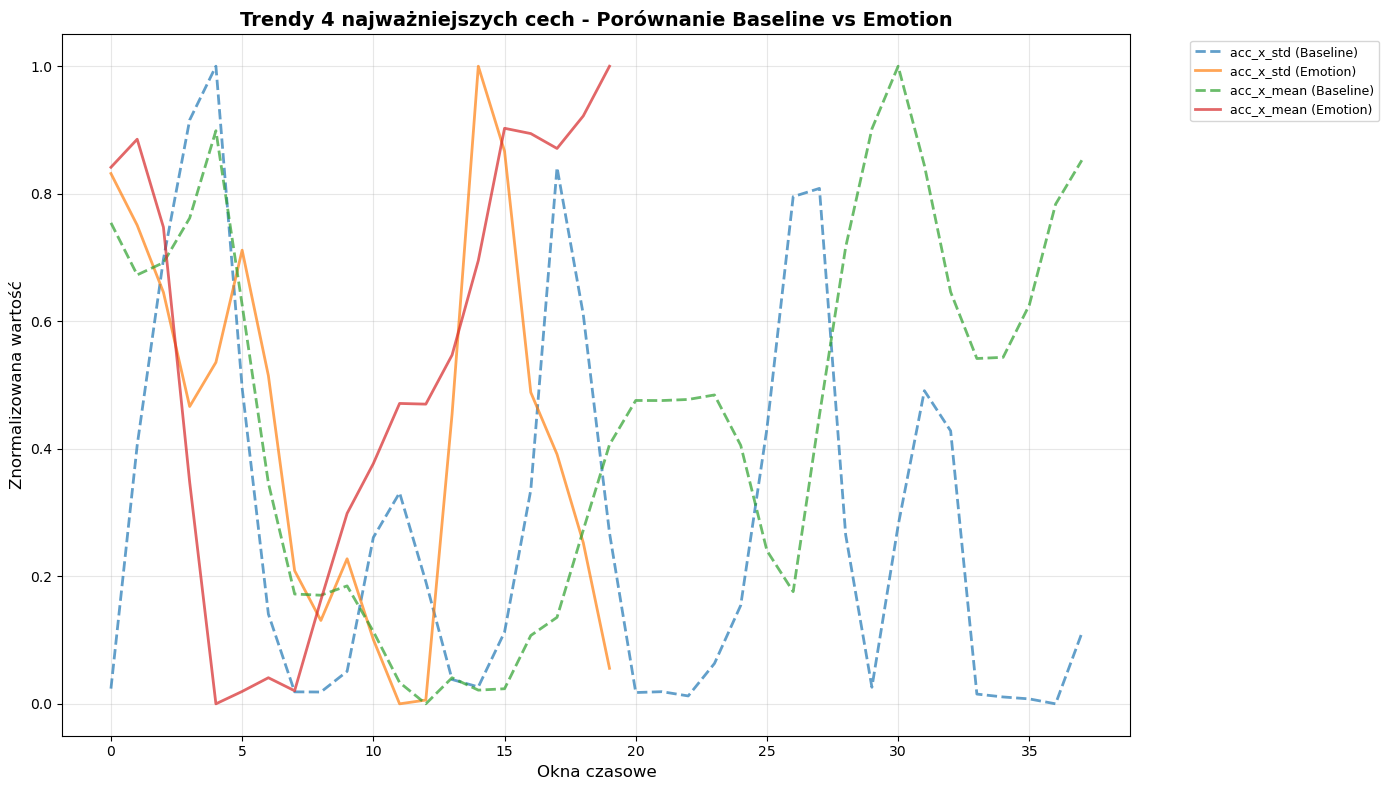

✅ Wykres porównawczy wygenerowany


In [36]:
# Wszystkie trendy na jednym wykresie (normalizowane)
plt.figure(figsize=(14, 8))

# Normalizuj do zakresu [0, 1] dla lepszej wizualizacji
def normalize(arr):
    arr_min, arr_max = np.min(arr), np.max(arr)
    if arr_max - arr_min > 0:
        return (arr - arr_min) / (arr_max - arr_min)
    return arr

for feat in top_4_features:
    baseline_key = f'{feat}_baseline'
    emotion_key = f'{feat}_emotion'
    
    if baseline_key in trend_dict:
        baseline_trend = trend_dict[baseline_key]
        time_points = np.arange(len(baseline_trend))
        baseline_norm = normalize(baseline_trend)
        plt.plot(time_points, baseline_norm, 
                label=f'{feat} (Baseline)', linewidth=2, alpha=0.7, linestyle='--')
    
    if emotion_key in trend_dict:
        emotion_trend = trend_dict[emotion_key]
        time_points = np.arange(len(emotion_trend))
        emotion_norm = normalize(emotion_trend)
        plt.plot(time_points, emotion_norm, 
                label=f'{feat} (Emotion)', linewidth=2, alpha=0.7)

if len(trend_dict) > 0:
    plt.xlabel('Okna czasowe', fontsize=12)
    plt.ylabel('Znormalizowana wartość', fontsize=12)
    plt.title('Trendy 4 najważniejszych cech - Porównanie Baseline vs Emotion', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("✅ Wykres porównawczy wygenerowany")
else:
    print("⚠️ Brak danych do wizualizacji - nie utworzono żadnych trendów")


---

## NOWE KROKI: SHAP + Model Time Series

Poniżej znajdują się nowe kroki, które:
1. Używają tego samego pipeline co `06_klasyfikacja_emocji_smote.ipynb` (kroki 2-6)
2. Identyfikują najważniejsze cechy używając **SHAP**
3. Trenują model time series (bez TensorFlow)
4. Porównują z regresją
5. Wykreślają trendy

**UWAGA:** Jeśli kroki 2-6 nie są jeszcze wykonane w komórkach powyżej, najpierw uruchom te komórki!


## KROK 7: Identyfikacja najważniejszych cech używając SHAP

Używamy SHAP (Shapley values) do identyfikacji cech, które najbardziej wpływają na klasyfikację.


KROK 7: IDENTYFIKACJA NAJWAŻNIEJSZYCH CECH UŻYWAJĄC SHAP

🔧 Obliczanie SHAP values...
   Obliczanie SHAP values (może to chwilę potrwać)...
⚠️ Ostrzeżenie: Długość mean_shap (2) != liczba cech (60)

📊 TOP 10 NAJWAŻNIEJSZYCH CECH (SHAP):
      feature  shap_importance
0  acc_x_mean         0.008362
1   acc_x_std         0.008362

📊 Wizualizacja SHAP values...


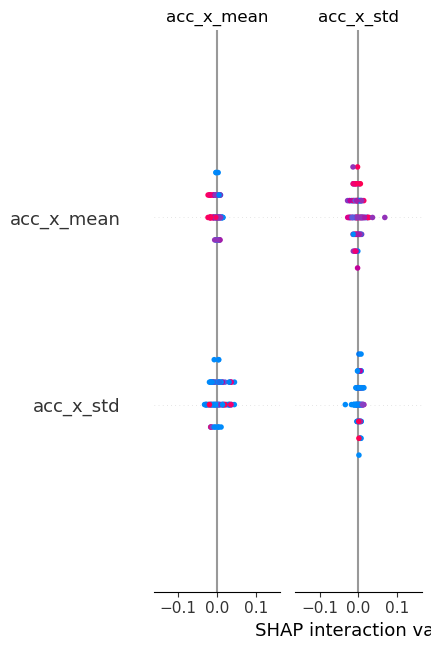


📊 Przeszukuję WSZYSTKIE cechy (2 cech), aby znaleźć najlepszą z każdego sygnału...

📊 Dostępne cechy w danych: 60 cech

🔍 DIAGNOSTYKA - Sygnały w całej liście cech:
   acc: 30 cech
   eda: 10 cech
   temp: 10 cech
   bvp: 10 cech

📊 Najlepsze cechy z każdego sygnału (z całej listy):
   acc: acc_x_std (importance: 0.008362, typ: std)
   bvp: bvp_std (importance: 0.000000, typ: std)
   eda: eda_std (importance: 0.000000, typ: std)
   temp: temp_std (importance: 0.000000, typ: std)

✅ WYMUSZONO wybór ACC: acc_x_std
✅ WYMUSZONO wybór TEMP: temp_std
✅ Dodano eda: eda_std
✅ Dodano bvp: bvp_std

✅ Wybrane top 4 ZRÓŻNICOWANE cechy do analizy trendów:
   1. acc_x_std (sygnał: acc, typ: std)
   2. temp_std (sygnał: temp, typ: std)
   3. eda_std (sygnał: eda, typ: std)
   4. bvp_std (sygnał: bvp, typ: std)


In [38]:
# ============================================================================
# KROK 7: IDENTYFIKACJA NAJWAŻNIEJSZYCH CECH UŻYWAJĄC SHAP
# ============================================================================

print("=" * 80)
print("KROK 7: IDENTYFIKACJA NAJWAŻNIEJSZYCH CECH UŻYWAJĄC SHAP")
print("=" * 80)

# Sprawdź dostępność zmiennych z kroków 2-6
required_vars = ['X_train_bal', 'y_train_bal', 'X_test', 'y_test', 'label_encoder']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"\n❌❌❌ BŁĄD: Brakujące zmienne: {', '.join(missing_vars)}")
    print("   Najpierw uruchom kroki 2-6 w kolejności!")
    raise NameError(f"Brakujące zmienne: {', '.join(missing_vars)}")

if not SHAP_AVAILABLE:
    print("\n⚠️ SHAP nie jest dostępny - używam Random Forest feature importance zamiast SHAP")
    print("   Aby użyć SHAP, zainstaluj: pip install shap")
    
    # Fallback: użyj Random Forest feature importance
    rf_for_features = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_for_features.fit(X_train_bal, y_train_bal)
    
    feature_importance = pd.DataFrame({
        'feature': X_train_bal.columns if isinstance(X_train_bal, pd.DataFrame) else [f'feature_{i}' for i in range(X_train_bal.shape[1])],
        'importance': rf_for_features.feature_importances_
    }).sort_values('importance', ascending=False)
    
    top_features = feature_importance.head(10)['feature'].tolist()
    print(f"\n📊 TOP 10 NAJWAŻNIEJSZYCH CECH (Random Forest):")
    print(feature_importance.head(10))
    
else:
    print("\n🔧 Obliczanie SHAP values...")
    
    # Trenuj model Random Forest dla SHAP
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_bal, y_train_bal)
    
    # Oblicz SHAP values (używamy TreeExplainer dla Random Forest)
    print("   Obliczanie SHAP values (może to chwilę potrwać)...")
    
    # Użyj mniejszej próbki dla SHAP (aby przyspieszyć)
    sample_size = min(100, len(X_train_bal))
    X_sample = X_train_bal.iloc[:sample_size] if isinstance(X_train_bal, pd.DataFrame) else X_train_bal[:sample_size]
    
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_sample)
    
    # Jeśli mamy 2 klasy, shap_values będzie listą
    if isinstance(shap_values, list):
        # Użyj wartości dla klasy 'emotion' (indeks 1)
        shap_values_class = shap_values[1]
    else:
        shap_values_class = shap_values
    
    # Oblicz średnie wartości bezwzględne SHAP dla każdej cechy
    # Upewnij się, że shap_values_class jest 2D (samples x features)
    shap_values_abs = np.abs(shap_values_class)
    
    # Jeśli jest 3D, zredukuj do 2D (użyj średniej po pierwszej osi)
    if shap_values_abs.ndim == 3:
        shap_values_abs = shap_values_abs.mean(axis=0)
    
    # Oblicz średnią po próbkach (axis=0 jeśli 2D)
    if shap_values_abs.ndim == 2:
        mean_shap = shap_values_abs.mean(axis=0)
    else:
        mean_shap = shap_values_abs
    
    # Upewnij się, że mean_shap jest 1D
    mean_shap = np.atleast_1d(mean_shap).flatten()
    
    # Pobierz nazwy cech
    if isinstance(X_train_bal, pd.DataFrame):
        feature_names = X_train_bal.columns.tolist()
    else:
        feature_names = [f'feature_{i}' for i in range(X_train_bal.shape[1])]
    
    # Upewnij się, że długości się zgadzają
    if len(mean_shap) != len(feature_names):
        print(f"⚠️ Ostrzeżenie: Długość mean_shap ({len(mean_shap)}) != liczba cech ({len(feature_names)})")
        min_len = min(len(mean_shap), len(feature_names))
        mean_shap = mean_shap[:min_len]
        feature_names = feature_names[:min_len]
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': mean_shap
    }).sort_values('shap_importance', ascending=False)
    
    top_features = feature_importance.head(10)['feature'].tolist()
    
    print(f"\n📊 TOP 10 NAJWAŻNIEJSZYCH CECH (SHAP):")
    print(feature_importance.head(10))
    
    # Wizualizacja SHAP
    print("\n📊 Wizualizacja SHAP values...")
    shap.summary_plot(shap_values_class, X_sample, plot_type="bar", show=False)
    plt.tight_layout()
    plt.show()

# Wybierz top 4 cechy do analizy trendów - zróżnicowane (różne sygnały i typy cech)
# Upewnij się, że feature_importance istnieje (może być z SHAP lub fallback)
if 'feature_importance' in locals() or 'feature_importance' in globals():
    # NOWA STRATEGIA: Nie wybieramy z top 15, tylko przeszukujemy WSZYSTKIE cechy
    # aby znaleźć najlepszą z każdego sygnału (ACC, BVP, EDA, TEMP)
    print(f"\n📊 Przeszukuję WSZYSTKIE cechy ({len(feature_importance)} cech), aby znaleźć najlepszą z każdego sygnału...")
    
    # Funkcja do wyodrębnienia sygnału i typu cechy z nazwy
    def parse_feature_name(feat_name):
        """Wyodrębnia sygnał (acc, bvp, eda, temp) i typ cechy (mean, std, rms, etc.)"""
        feat_lower = feat_name.lower()
        
        # Znajdź sygnał - sprawdź różne wzorce
        signal = None
        # Sprawdź dokładne dopasowania na początku lub po podkreśleniu
        if feat_lower.startswith('acc_') or '_acc_' in feat_lower or feat_lower.startswith('acc'):
            signal = 'acc'
        elif feat_lower.startswith('bvp_') or '_bvp_' in feat_lower or feat_lower.startswith('bvp'):
            signal = 'bvp'
        elif feat_lower.startswith('eda_') or '_eda_' in feat_lower or feat_lower.startswith('eda'):
            signal = 'eda'
        elif feat_lower.startswith('temp_') or '_temp_' in feat_lower or feat_lower.startswith('temp'):
            signal = 'temp'
        
        # Znajdź typ cechy
        feature_type = None
        for ftype in ['mean', 'std', 'rms', 'range', 'min', 'max', 'median', 'kurtosis', 'skewness']:
            if f'_{ftype}' in feat_lower or feat_lower.endswith(f'_{ftype}'):
                feature_type = ftype
                break
        
        return signal, feature_type
    
    # Wybierz 4 najbardziej zróżnicowane cechy - WYMUSZ różnorodność sygnałów
    selected_features = []
    used_signals = set()
    used_types = set()
    
    # Przeszukaj WSZYSTKIE cechy, aby znaleźć najlepszą z każdego sygnału
    # WAŻNE: Sprawdź cechy w X_train_bal, nie tylko w feature_importance (bo SHAP może zwrócić tylko kilka)
    importance_col = feature_importance.columns[1]  # 'shap_importance' lub 'importance'
    signals_to_find = ['acc', 'bvp', 'eda', 'temp']
    best_by_signal = {}
    
    # Pobierz WSZYSTKIE dostępne cechy z X_train_bal (nie tylko z feature_importance)
    if isinstance(X_train_bal, pd.DataFrame):
        all_available_features = X_train_bal.columns.tolist()
    else:
        all_available_features = [f'feature_{i}' for i in range(X_train_bal.shape[1])]
    
    print(f"\n📊 Dostępne cechy w danych: {len(all_available_features)} cech")
    
    # Przeszukaj wszystkie dostępne cechy
    all_candidates_info = []
    
    # Najpierw dodaj cechy z feature_importance (mają importance)
    for feat in feature_importance['feature'].tolist():
        if feat in all_available_features:
            signal, ftype = parse_feature_name(feat)
            importance_val = feature_importance[feature_importance['feature'] == feat].iloc[0][importance_col]
            all_candidates_info.append({
                'feature': feat,
                'signal': signal,
                'type': ftype,
                'importance': importance_val
            })
    
    # Teraz dodaj pozostałe cechy z all_available_features (nie mają importance, użyj 0.0)
    for feat in all_available_features:
        if feat not in feature_importance['feature'].tolist():
            signal, ftype = parse_feature_name(feat)
            # Jeśli nie ma w feature_importance, użyj importance = 0.0 (będzie wybrane tylko jeśli brakuje sygnału)
            all_candidates_info.append({
                'feature': feat,
                'signal': signal,
                'type': ftype,
                'importance': 0.0
            })
    
    # Diagnostyka: sprawdź jakie sygnały są w całej liście
    print(f"\n🔍 DIAGNOSTYKA - Sygnały w całej liście cech:")
    signal_counts = {}
    for candidate in all_candidates_info:
        signal = candidate['signal']
        if signal:
            signal_counts[signal] = signal_counts.get(signal, 0) + 1
    for sig, count in sorted(signal_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"   {sig}: {count} cech")
    
    # Dla każdego sygnału znajdź najlepszą cechę
    # Sortuj najpierw po importance (malejąco), aby preferować cechy z feature_importance
    all_candidates_info.sort(key=lambda x: x['importance'], reverse=True)
    
    for candidate in all_candidates_info:
        signal = candidate['signal']
        if signal and signal.lower() in signals_to_find:
            signal_lower = signal.lower()
            
            # Jeśli nie mamy jeszcze cechy dla tego sygnału, zapisz
            if signal_lower not in best_by_signal:
                best_by_signal[signal_lower] = candidate
            else:
                # Jeśli mamy już cechę dla tego sygnału, sprawdź czy nowa jest lepsza
                current = best_by_signal[signal_lower]
                
                # Preferuj cechy z importance > 0 (z feature_importance)
                if candidate['importance'] > 0 and current['importance'] == 0:
                    best_by_signal[signal_lower] = candidate
                elif candidate['importance'] == 0 and current['importance'] > 0:
                    # Obecna ma importance, nowa nie - zostaw obecną
                    pass
                else:
                    # Obie mają ten sam status importance, preferuj std zamiast mean
                    if candidate['type'] == 'std' and current['type'] != 'std':
                        best_by_signal[signal_lower] = candidate
                    elif candidate['type'] == current['type']:
                        # Jeśli ten sam typ, wybierz tę z wyższą importance
                        if candidate['importance'] > current['importance']:
                            best_by_signal[signal_lower] = candidate
                    elif current['type'] != 'std' and candidate['importance'] > current['importance']:
                        # Jeśli obecna nie jest std, a nowa ma wyższą importance, zamień
                        best_by_signal[signal_lower] = candidate
    
    print(f"\n📊 Najlepsze cechy z każdego sygnału (z całej listy):")
    for sig in signals_to_find:
        if sig in best_by_signal:
            candidate = best_by_signal[sig]
            print(f"   {sig}: {candidate['feature']} (importance: {candidate['importance']:.6f}, typ: {candidate['type']})")
        else:
            print(f"   {sig}: ❌ Nie znaleziono")
    
    # WYMUSZ wybór przynajmniej ACC i TEMP
    # 1. Najpierw wybierz najlepsze z dostępnych sygnałów
    selected_by_signal = list(best_by_signal.values())
    selected_by_signal.sort(key=lambda x: x['importance'], reverse=True)
    
    # 2. WYMUSZ wybór ACC i TEMP (nawet jeśli mają niższą importance)
    selected_features = []
    used_signals = set()
    
    # Priorytet 1: Zawsze wybierz ACC (najlepszą cechę ACC)
    if 'acc' in best_by_signal:
        acc_feature = best_by_signal['acc']['feature']
        selected_features.append(acc_feature)
        used_signals.add('acc')
        print(f"\n✅ WYMUSZONO wybór ACC: {acc_feature}")
    
    # Priorytet 2: Zawsze wybierz TEMP (najlepszą cechę TEMP)
    if 'temp' in best_by_signal:
        temp_feature = best_by_signal['temp']['feature']
        if temp_feature not in selected_features:
            selected_features.append(temp_feature)
            used_signals.add('temp')
            print(f"✅ WYMUSZONO wybór TEMP: {temp_feature}")
    else:
        print(f"⚠️ TEMP nie znaleziono w best_by_signal - szukam w całej liście...")
        # Szukaj TEMP w całej liście
        for candidate in all_candidates_info:
            if candidate['signal'] and candidate['signal'].lower() == 'temp':
                temp_feature = candidate['feature']
                selected_features.append(temp_feature)
                used_signals.add('temp')
                print(f"✅ Znaleziono TEMP: {temp_feature} (importance: {candidate['importance']:.6f})")
                break
    
    # Priorytet 3: Dodaj pozostałe sygnały (BVP, EDA) jeśli są dostępne
    for candidate in selected_by_signal:
        if len(selected_features) >= 4:
            break
        signal = candidate['signal']
        feat = candidate['feature']
        if signal and signal.lower() not in used_signals and feat not in selected_features:
            selected_features.append(feat)
            used_signals.add(signal.lower())
            print(f"✅ Dodano {signal.lower()}: {feat}")
    
    # Jeśli nadal nie mamy 4 cech, dodaj najlepsze z pozostałych (nawet jeśli sygnał się powtarza)
    if len(selected_features) < 4:
        print(f"\n⚠️ Mamy tylko {len(selected_features)} cech, dodaję najlepsze z pozostałych...")
        
        # Sortuj wszystkie cechy po importance
        all_candidates_info.sort(key=lambda x: x['importance'], reverse=True)
        
        for candidate in all_candidates_info:
            if len(selected_features) >= 4:
                break
            feat = candidate['feature']
            if feat not in selected_features:
                selected_features.append(feat)
                print(f"   Dodano: {feat} (sygnał: {candidate['signal']}, importance: {candidate['importance']:.6f})")
    
    top_4_features = selected_features[:4]
    
    print(f"\n✅ Wybrane top 4 ZRÓŻNICOWANE cechy do analizy trendów:")
    for i, feat in enumerate(top_4_features, 1):
        signal, ftype = parse_feature_name(feat)
        signal_str = signal if signal else '?'
        ftype_str = ftype if ftype else '?'
        print(f"   {i}. {feat} (sygnał: {signal_str}, typ: {ftype_str})")
    
else:
    # Fallback: użyj pierwszych 4 cech
    if isinstance(X_train_bal, pd.DataFrame):
        top_4_features = X_train_bal.columns[:4].tolist()
    else:
        top_4_features = [f'feature_{i}' for i in range(min(4, X_train_bal.shape[1]))]
    print(f"\n⚠️ Nie można utworzyć feature_importance - używam pierwszych 4 cech: {top_4_features}")

# Zapisz top_4_features do zmiennej globalnej
globals()['top_4_features'] = top_4_features


## KROK 8: Model Time Series (bez TensorFlow) + Porównanie z Regresją

Trenujemy model time series używając sklearn (bez TensorFlow) i porównujemy z Logistic Regression.


KROK 8: MODEL TIME SERIES + PORÓWNANIE Z REGRESJĄ

🔧 Trenowanie modelu Time Series (Random Forest)...

📊 WYNIKI MODELU TIME SERIES (Random Forest):
   Train Accuracy: 1.0000
   Test Accuracy: 0.6341
   Test Balanced Accuracy: 0.5846
   Test Macro F1: 0.5859

🔧 Trenowanie modelu Regresji (Logistic Regression)...

📊 WYNIKI MODELU REGRESJI (Logistic Regression):
   Train Accuracy: 0.7407
   Test Accuracy: 0.8049
   Test Balanced Accuracy: 0.8179
   Test Macro F1: 0.7990

PORÓWNANIE MODELI
                  Metric  Time Series (RF)  Regression (LR)  Difference
        Accuracy (Train)          1.000000         0.740741    0.259259
         Accuracy (Test)          0.634146         0.804878   -0.170732
Balanced Accuracy (Test)          0.584615         0.817949   -0.233333
         Macro F1 (Test)          0.585859         0.799020   -0.213161

✅ Model Regresji (Logistic Regression) jest lepszy niż Time Series!
   Różnica w Accuracy: 0.1707

📊 CONFUSION MATRICES:


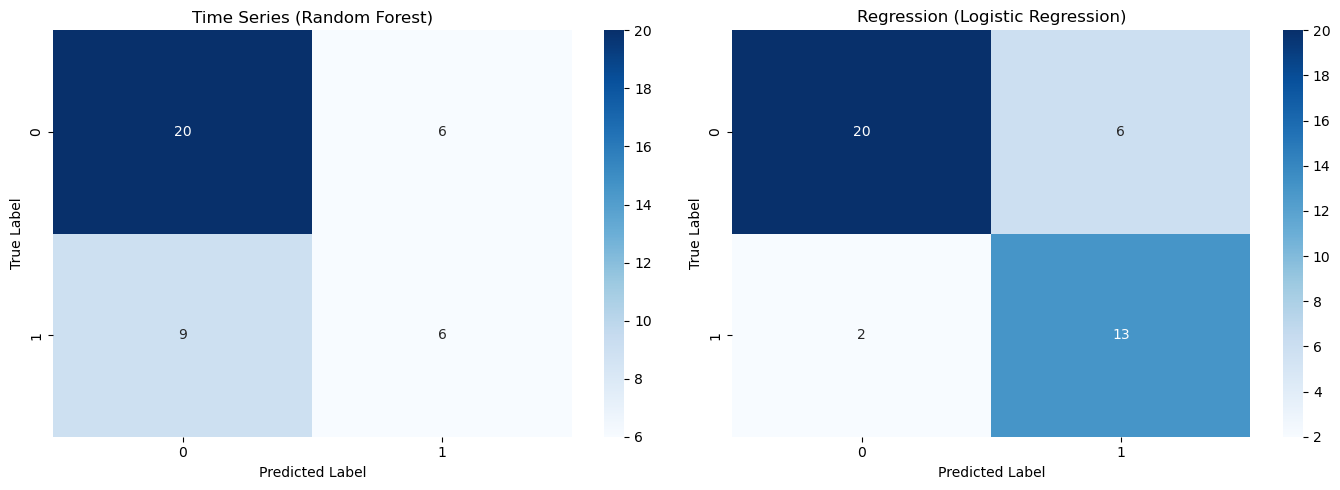

In [39]:
# ============================================================================
# KROK 8: MODEL TIME SERIES + PORÓWNANIE Z REGRESJĄ
# ============================================================================

print("=" * 80)
print("KROK 8: MODEL TIME SERIES + PORÓWNANIE Z REGRESJĄ")
print("=" * 80)

# Sprawdź dostępność zmiennych
required_vars = ['X_train_bal', 'y_train_bal', 'X_test', 'y_test', 'label_encoder']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"\n❌❌❌ BŁĄD: Brakujące zmienne: {', '.join(missing_vars)}")
    print("   Najpierw uruchom kroki 2-6 w kolejności!")
    raise NameError(f"Brakujące zmienne: {', '.join(missing_vars)}")

# 1. Model Time Series - używamy Random Forest jako model time series (proste podejście)
# Dla prawdziwego time series można użyć TimeSeriesSplit i innych technik
print("\n🔧 Trenowanie modelu Time Series (Random Forest)...")
model_timeseries = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
model_timeseries.fit(X_train_bal, y_train_bal)

# Predykcje
y_pred_timeseries_train = model_timeseries.predict(X_train_bal)
y_pred_timeseries_test = model_timeseries.predict(X_test)

# Metryki
acc_timeseries_train = accuracy_score(y_train_bal, y_pred_timeseries_train)
acc_timeseries_test = accuracy_score(y_test, y_pred_timeseries_test)
bal_acc_timeseries_test = balanced_accuracy_score(y_test, y_pred_timeseries_test)
f1_timeseries_test = f1_score(y_test, y_pred_timeseries_test, average='macro')

print(f"\n📊 WYNIKI MODELU TIME SERIES (Random Forest):")
print(f"   Train Accuracy: {acc_timeseries_train:.4f}")
print(f"   Test Accuracy: {acc_timeseries_test:.4f}")
print(f"   Test Balanced Accuracy: {bal_acc_timeseries_test:.4f}")
print(f"   Test Macro F1: {f1_timeseries_test:.4f}")

# 2. Model Regresji (Logistic Regression)
print("\n🔧 Trenowanie modelu Regresji (Logistic Regression)...")
model_regression = LogisticRegression(random_state=42, max_iter=1000)
model_regression.fit(X_train_bal, y_train_bal)

# Predykcje
y_pred_regression_train = model_regression.predict(X_train_bal)
y_pred_regression_test = model_regression.predict(X_test)

# Metryki
acc_regression_train = accuracy_score(y_train_bal, y_pred_regression_train)
acc_regression_test = accuracy_score(y_test, y_pred_regression_test)
bal_acc_regression_test = balanced_accuracy_score(y_test, y_pred_regression_test)
f1_regression_test = f1_score(y_test, y_pred_regression_test, average='macro')

print(f"\n📊 WYNIKI MODELU REGRESJI (Logistic Regression):")
print(f"   Train Accuracy: {acc_regression_train:.4f}")
print(f"   Test Accuracy: {acc_regression_test:.4f}")
print(f"   Test Balanced Accuracy: {bal_acc_regression_test:.4f}")
print(f"   Test Macro F1: {f1_regression_test:.4f}")

# 3. Porównanie
print("\n" + "=" * 80)
print("PORÓWNANIE MODELI")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy (Train)', 'Accuracy (Test)', 'Balanced Accuracy (Test)', 'Macro F1 (Test)'],
    'Time Series (RF)': [acc_timeseries_train, acc_timeseries_test, bal_acc_timeseries_test, f1_timeseries_test],
    'Regression (LR)': [acc_regression_train, acc_regression_test, bal_acc_regression_test, f1_regression_test]
})

comparison_df['Difference'] = comparison_df['Time Series (RF)'] - comparison_df['Regression (LR)']
print(comparison_df.to_string(index=False))

# Sprawdź który model jest lepszy
if acc_timeseries_test > acc_regression_test:
    print(f"\n✅ Model Time Series (Random Forest) jest lepszy niż Regresja!")
    print(f"   Różnica w Accuracy: {acc_timeseries_test - acc_regression_test:.4f}")
    best_model = model_timeseries
    best_model_name = "Time Series (Random Forest)"
else:
    print(f"\n✅ Model Regresji (Logistic Regression) jest lepszy niż Time Series!")
    print(f"   Różnica w Accuracy: {acc_regression_test - acc_timeseries_test:.4f}")
    best_model = model_regression
    best_model_name = "Regression (Logistic Regression)"

# Confusion matrices
print("\n📊 CONFUSION MATRICES:")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time Series
cm_timeseries = confusion_matrix(y_test, y_pred_timeseries_test)
sns.heatmap(cm_timeseries, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Time Series (Random Forest)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Regression
cm_regression = confusion_matrix(y_test, y_pred_regression_test)
sns.heatmap(cm_regression, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Regression (Logistic Regression)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


## KROK 9: Wykresy trendów najważniejszych cech

Wykreślamy trendy najważniejszych cech (zidentyfikowanych przez SHAP) w czasie dla klas baseline i emotion.


KROK 9: WYKRESY TRENDÓW NAJWAŻNIEJSZYCH CECH

🔧 Obliczanie trendów dla 4 cech...

   📊 Przetwarzam acc_x_std...
      Znaleziono 80 wartości baseline, 43 wartości emotion
      ✅ Utworzono 38 okien dla baseline
      ✅ Utworzono 20 okien dla emotion

   📊 Przetwarzam temp_std...

      🔍 DIAGNOSTYKA TEMPERATURY:
         Baseline - średnia: 1.6795, min: 0.0025, max: 133.0061
         Emotion - średnia: 0.0182, min: 0.0059, max: 0.0557
         Różnica (baseline - emotion): 1.6613
         Baseline - mediana: 0.0154, std: 14.8686
         Emotion - mediana: 0.0153, std: 0.0111
         ⚠️ UWAGA: Baseline ma wartości znacznie wyższe niż emotion!
         ⚠️ UWAGA: Średnia temperatura baseline jest wyższa niż emotion!
         💡 To może być błąd w przypisaniu etykiet lub rzeczywisty wzorzec w danych
         💡 W WESAD: 'emotion' = stress + amusement
         💡 Temperatura może wzrastać w stresie, ale spadać w amusement
         💡 Jeśli 'emotion' zawiera głównie amusement, to może wyjaśnia

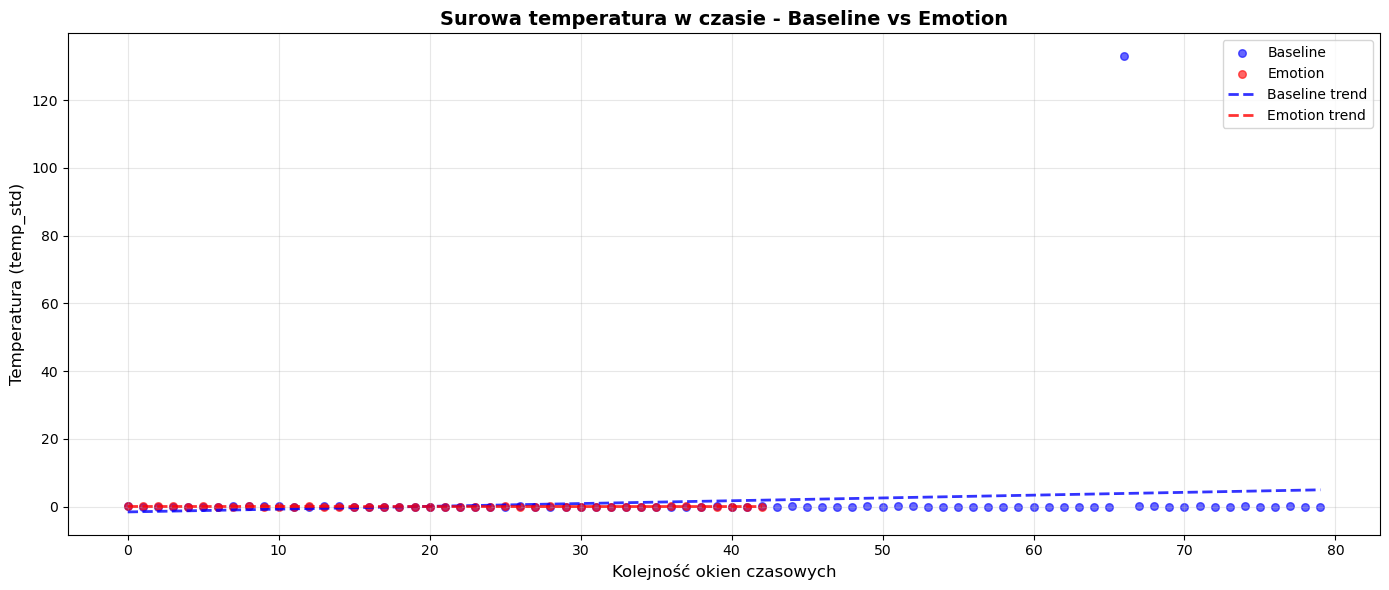

         ✅ Wykres wygenerowany - sprawdź czy baseline ma 'pik'
      Znaleziono 80 wartości baseline, 43 wartości emotion
      ✅ Utworzono 38 okien dla baseline
      ✅ Utworzono 20 okien dla emotion

   📊 Przetwarzam eda_std...
      Znaleziono 80 wartości baseline, 43 wartości emotion
      ✅ Utworzono 38 okien dla baseline
      ✅ Utworzono 20 okien dla emotion

   📊 Przetwarzam bvp_std...
      Znaleziono 80 wartości baseline, 43 wartości emotion
      ✅ Utworzono 38 okien dla baseline
      ✅ Utworzono 20 okien dla emotion

✅ Obliczono trendy dla 8 serii czasowych

📊 Utworzone trendy:
   acc_x_std_baseline: 38 punktów
   acc_x_std_emotion: 20 punktów
   bvp_std_baseline: 38 punktów
   bvp_std_emotion: 20 punktów
   eda_std_baseline: 38 punktów
   eda_std_emotion: 20 punktów
   temp_std_baseline: 38 punktów
   temp_std_emotion: 20 punktów


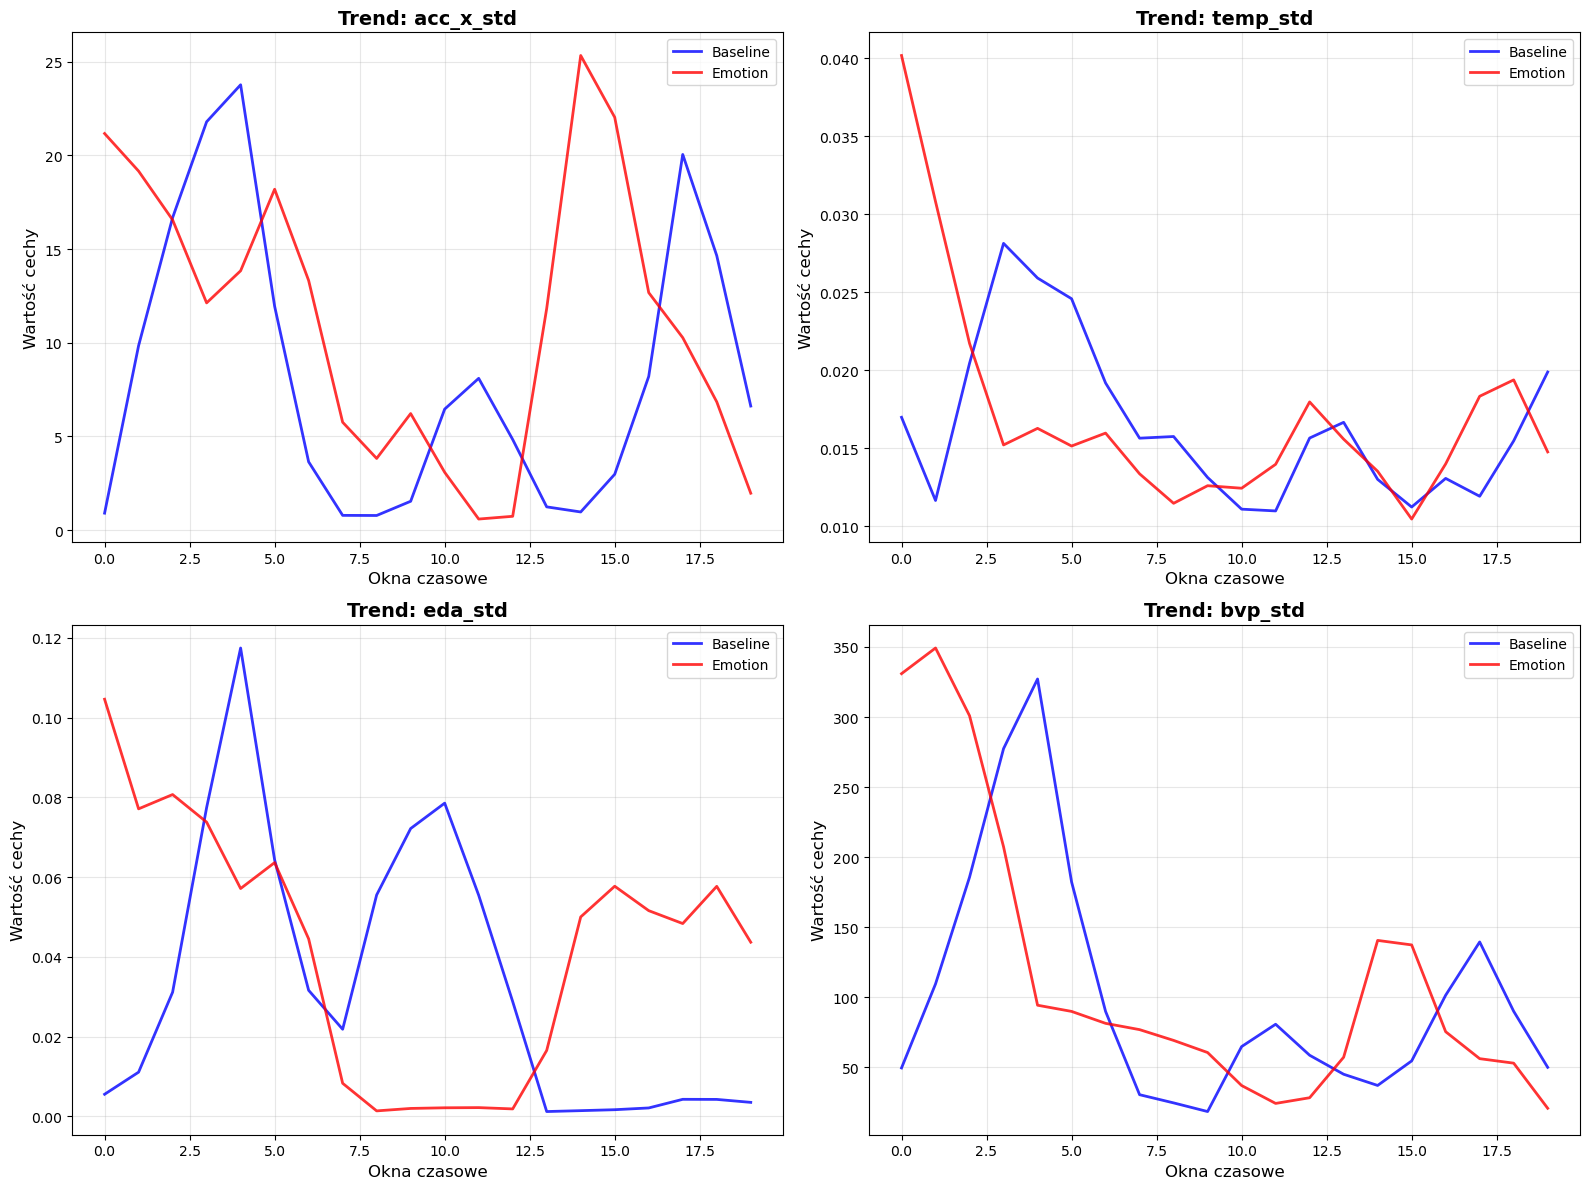

✅ Wykresy trendów wygenerowane


In [43]:
# ============================================================================
# KROK 9: WYKRESY TRENDÓW NAJWAŻNIEJSZYCH CECH
# ============================================================================

print("=" * 80)
print("KROK 9: WYKRESY TRENDÓW NAJWAŻNIEJSZYCH CECH")
print("=" * 80)

# Sprawdź dostępność zmiennych
required_vars = ['top_4_features', 'segmented_df']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"\n❌❌❌ BŁĄD: Brakujące zmienne: {', '.join(missing_vars)}")
    if 'top_4_features' not in globals():
        print("   Najpierw uruchom KROK 7 (SHAP) aby utworzyć top_4_features!")
    if 'segmented_df' not in globals():
        print("   Najpierw uruchom KROK 3 (SEGMENTACJA) aby utworzyć segmented_df!")
    raise NameError(f"Brakujące zmienne: {', '.join(missing_vars)}")

# Parametry okienkowania dla trendów
window_size_trend = 5  # Liczba okien do uśrednienia
stride_trend = 2

# Zbierz trendy dla każdej z top 4 cech
trend_dict = {}

print(f"\n🔧 Obliczanie trendów dla {len(top_4_features)} cech...")

for feat in top_4_features:
    print(f"\n   📊 Przetwarzam {feat}...")
    
    # Zbierz wartości tej cechy dla baseline i emotion w kolejności czasowej
    baseline_values = []
    emotion_values = []
    
    # Iteruj przez segmented_df w kolejności czasowej (sortuj po subject i window_start)
    if 'segmented_df' in globals() and feat in segmented_df.columns:
        # Sortuj po subject i window_start aby zachować kolejność czasową
        df_sorted = segmented_df.sort_values(['subject', 'window_start']).copy()
        
        # DIAGNOSTYKA: Sprawdź surowe wartości dla temperatury
        if 'temp' in feat.lower():
            print(f"\n      🔍 DIAGNOSTYKA TEMPERATURY:")
            temp_baseline_raw = df_sorted[df_sorted['label'] == 'baseline'][feat].dropna()
            temp_emotion_raw = df_sorted[df_sorted['label'] == 'emotion'][feat].dropna()
            
            # Sprawdź jakie fazy są w "emotion"
            if 'phase' in df_sorted.columns:
                emotion_phases = df_sorted[df_sorted['label'] == 'emotion']['phase'].unique()
                baseline_phases = df_sorted[df_sorted['label'] == 'baseline']['phase'].unique()
                print(f"         Fazy w 'baseline': {sorted(baseline_phases)}")
                print(f"         Fazy w 'emotion': {sorted(emotion_phases)}")
            
            if len(temp_baseline_raw) > 0 and len(temp_emotion_raw) > 0:
                print(f"         Baseline - średnia: {temp_baseline_raw.mean():.4f}, min: {temp_baseline_raw.min():.4f}, max: {temp_baseline_raw.max():.4f}")
                print(f"         Emotion - średnia: {temp_emotion_raw.mean():.4f}, min: {temp_emotion_raw.min():.4f}, max: {temp_emotion_raw.max():.4f}")
                print(f"         Różnica (baseline - emotion): {temp_baseline_raw.mean() - temp_emotion_raw.mean():.4f}")
                
                # Sprawdź rozkład wartości
                print(f"         Baseline - mediana: {temp_baseline_raw.median():.4f}, std: {temp_baseline_raw.std():.4f}")
                print(f"         Emotion - mediana: {temp_emotion_raw.median():.4f}, std: {temp_emotion_raw.std():.4f}")
                
                # Sprawdź czy są jakieś anomalie
                if temp_baseline_raw.max() > temp_emotion_raw.max() + 2 * temp_emotion_raw.std():
                    print(f"         ⚠️ UWAGA: Baseline ma wartości znacznie wyższe niż emotion!")
                if temp_baseline_raw.mean() > temp_emotion_raw.mean():
                    print(f"         ⚠️ UWAGA: Średnia temperatura baseline jest wyższa niż emotion!")
                    print(f"         💡 To może być błąd w przypisaniu etykiet lub rzeczywisty wzorzec w danych")
                    print(f"         💡 W WESAD: 'emotion' = stress + amusement")
                    print(f"         💡 Temperatura może wzrastać w stresie, ale spadać w amusement")
                    print(f"         💡 Jeśli 'emotion' zawiera głównie amusement, to może wyjaśniać niższą temperaturę")
                
                # Sprawdź wartości w czasie (czy są jakieś wzorce)
                if 'window_start' in df_sorted.columns:
                    baseline_times = df_sorted[df_sorted['label'] == 'baseline'].groupby('subject')['window_start'].count()
                    emotion_times = df_sorted[df_sorted['label'] == 'emotion'].groupby('subject')['window_start'].count()
                    print(f"         Liczba okien per subject - Baseline: {baseline_times.to_dict()}")
                    print(f"         Liczba okien per subject - Emotion: {emotion_times.to_dict()}")
                
                # WIZUALIZACJA: Surowa temperatura w czasie (przed okienkowaniem)
                print(f"\n      📊 WIZUALIZACJA SUROWEJ TEMPERATURY W CZASIE:")
                try:
                    import matplotlib.pyplot as plt
                    
                    # Przygotuj dane do wizualizacji
                    baseline_df = df_sorted[df_sorted['label'] == 'baseline'].copy()
                    emotion_df = df_sorted[df_sorted['label'] == 'emotion'].copy()
                    
                    if len(baseline_df) > 0 and len(emotion_df) > 0:
                        # Stwórz indeks czasowy (kolejność okien)
                        baseline_df = baseline_df.sort_values(['subject', 'window_start'])
                        emotion_df = emotion_df.sort_values(['subject', 'window_start'])
                        
                        baseline_df['time_idx'] = range(len(baseline_df))
                        emotion_df['time_idx'] = range(len(emotion_df))
                        
                        # Wykres
                        fig, ax = plt.subplots(figsize=(14, 6))
                        
                        ax.scatter(baseline_df['time_idx'], baseline_df[feat], 
                                  label='Baseline', alpha=0.6, s=30, color='blue')
                        ax.scatter(emotion_df['time_idx'], emotion_df[feat], 
                                  label='Emotion', alpha=0.6, s=30, color='red')
                        
                        # Linie trendu
                        if len(baseline_df) > 1:
                            z_b = np.polyfit(baseline_df['time_idx'], baseline_df[feat].dropna(), 1)
                            p_b = np.poly1d(z_b)
                            ax.plot(baseline_df['time_idx'], p_b(baseline_df['time_idx']), 
                                   "b--", alpha=0.8, linewidth=2, label='Baseline trend')
                        
                        if len(emotion_df) > 1:
                            z_e = np.polyfit(emotion_df['time_idx'], emotion_df[feat].dropna(), 1)
                            p_e = np.poly1d(z_e)
                            ax.plot(emotion_df['time_idx'], p_e(emotion_df['time_idx']), 
                                   "r--", alpha=0.8, linewidth=2, label='Emotion trend')
                        
                        ax.set_xlabel('Kolejność okien czasowych', fontsize=12)
                        ax.set_ylabel(f'Temperatura ({feat})', fontsize=12)
                        ax.set_title('Surowa temperatura w czasie - Baseline vs Emotion', fontsize=14, fontweight='bold')
                        ax.legend(fontsize=10)
                        ax.grid(True, alpha=0.3)
                        plt.tight_layout()
                        plt.show()
                        
                        print(f"         ✅ Wykres wygenerowany - sprawdź czy baseline ma 'pik'")
                except Exception as e:
                    print(f"         ⚠️ Nie udało się wygenerować wykresu: {e}")
        
        for idx, row in df_sorted.iterrows():
            label = row['label']
            value = row[feat]
            
            if not np.isnan(value) and pd.notna(value):
                if label == 'baseline':
                    baseline_values.append(value)
                elif label == 'emotion':
                    emotion_values.append(value)
        
        print(f"      Znaleziono {len(baseline_values)} wartości baseline, {len(emotion_values)} wartości emotion")
        
        # Podziel na okna i oblicz średnie
        if len(baseline_values) >= window_size_trend:
            baseline_windows = []
            for i in range(0, len(baseline_values) - window_size_trend + 1, stride_trend):
                window = baseline_values[i:i + window_size_trend]
                baseline_windows.append(np.mean(window))
            trend_dict[f'{feat}_baseline'] = np.array(baseline_windows)
            print(f"      ✅ Utworzono {len(baseline_windows)} okien dla baseline")
        else:
            print(f"      ⚠️ Za mało wartości baseline ({len(baseline_values)} < {window_size_trend})")
        
        if len(emotion_values) >= window_size_trend:
            emotion_windows = []
            for i in range(0, len(emotion_values) - window_size_trend + 1, stride_trend):
                window = emotion_values[i:i + window_size_trend]
                emotion_windows.append(np.mean(window))
            trend_dict[f'{feat}_emotion'] = np.array(emotion_windows)
            print(f"      ✅ Utworzono {len(emotion_windows)} okien dla emotion")
        else:
            print(f"      ⚠️ Za mało wartości emotion ({len(emotion_values)} < {window_size_trend})")
    
    else:
        if 'segmented_df' not in globals():
            print(f"      ❌ segmented_df nie jest dostępne!")
        elif feat not in segmented_df.columns:
            print(f"      ❌ Cecha {feat} nie znaleziona w segmented_df")
            print(f"      Dostępne cechy (pierwsze 10): {list(segmented_df.columns[:10])}")

print(f"\n✅ Obliczono trendy dla {len(trend_dict)} serii czasowych")

# Diagnostyka - sprawdź co jest w trend_dict
if len(trend_dict) > 0:
    print(f"\n📊 Utworzone trendy:")
    for key in sorted(trend_dict.keys()):
        print(f"   {key}: {len(trend_dict[key])} punktów")
else:
    print(f"\n⚠️ UWAGA: trend_dict jest pusty!")
    print(f"   Sprawdź:")
    print(f"   - Czy top_4_features są poprawne: {top_4_features}")
    if 'segmented_df' in globals():
        print(f"   - Dostępne cechy w segmented_df (pierwsze 20): {list(segmented_df.columns[:20])}")
        print(f"   - Czy top_4_features są w segmented_df:")
        for feat in top_4_features:
            if feat in segmented_df.columns:
                print(f"     ✅ {feat} - dostępne")
            else:
                print(f"     ❌ {feat} - NIE dostępne")
    else:
        print(f"   - segmented_df nie jest dostępne!")

# Wizualizacja trendów
if len(trend_dict) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, feat in enumerate(top_4_features[:4]):
        ax = axes[idx]
        
        baseline_key = f'{feat}_baseline'
        emotion_key = f'{feat}_emotion'
        
        has_baseline = baseline_key in trend_dict
        has_emotion = emotion_key in trend_dict
        
        if has_baseline or has_emotion:
            if has_baseline:
                baseline_trend = trend_dict[baseline_key]
                time_points_b = np.arange(len(baseline_trend))
                ax.plot(time_points_b, baseline_trend, 
                        label='Baseline', linewidth=2, alpha=0.8, color='blue')
            
            if has_emotion:
                emotion_trend = trend_dict[emotion_key]
                time_points_e = np.arange(len(emotion_trend))
                ax.plot(time_points_e, emotion_trend, 
                        label='Emotion', linewidth=2, alpha=0.8, color='red')
            
            # Jeśli oba są dostępne, użyj minimalnej długości
            if has_baseline and has_emotion:
                min_len = min(len(baseline_trend), len(emotion_trend))
                time_points = np.arange(min_len)
                ax.clear()
                ax.plot(time_points, baseline_trend[:min_len], 
                        label='Baseline', linewidth=2, alpha=0.8, color='blue')
                ax.plot(time_points, emotion_trend[:min_len], 
                        label='Emotion', linewidth=2, alpha=0.8, color='red')
            
            ax.set_xlabel('Okna czasowe', fontsize=12)
            ax.set_ylabel('Wartość cechy', fontsize=12)
            ax.set_title(f'Trend: {feat}', fontsize=14, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'Brak danych dla {feat}', 
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{feat} - Brak danych', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    print("✅ Wykresy trendów wygenerowane")
else:
    print("⚠️ Brak danych do wizualizacji - nie utworzono żadnych trendów")


## KROK 10: GENEROWANIE RAPORTU STREAMLIT

Ta komórka generuje ładny raport Streamlit z wynikami analizy:
- Porównanie modeli (Time Series vs Regression)
- SHAP feature importance
- Trendy czasowe najważniejszych cech
- Confusion matrices
- Metryki i podsumowanie


In [45]:
# ============================================================================
# KROK 10: GENEROWANIE RAPORTU STREAMLIT
# ============================================================================

print("=" * 80)
print("KROK 10: GENEROWANIE RAPORTU STREAMLIT")
print("=" * 80)

import json
from pathlib import Path

# Sprawdź dostępność zmiennych
required_vars = ['model_timeseries', 'model_regression', 'X_test', 'y_test', 
                 'y_pred_timeseries_test', 'y_pred_regression_test', 
                 'label_encoder', 'top_4_features']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"\n❌❌❌ BŁĄD: Brakujące zmienne: {', '.join(missing_vars)}")
    print("   Najpierw uruchom kroki 7-9 w kolejności!")
    raise NameError(f"Brakujące zmienne: {', '.join(missing_vars)}")

# Utwórz folder dla wyników
PROJECT_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep")
results_dir = PROJECT_ROOT / "results"
results_dir.mkdir(exist_ok=True)

print(f"\n📁 Folder wyników: {results_dir}")

# ============================================================================
# 1. ZBIERZ WSZYSTKIE WYNIKI
# ============================================================================

print("\n📊 Zbieranie wyników...")

# Metryki dla obu modeli
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix

# Time Series (Random Forest)
acc_timeseries = accuracy_score(y_test, y_pred_timeseries_test)
bal_acc_timeseries = balanced_accuracy_score(y_test, y_pred_timeseries_test)
f1_timeseries = f1_score(y_test, y_pred_timeseries_test, average='macro')
cm_timeseries = confusion_matrix(y_test, y_pred_timeseries_test)

# Regression (Logistic Regression)
acc_regression = accuracy_score(y_test, y_pred_regression_test)
bal_acc_regression = balanced_accuracy_score(y_test, y_pred_regression_test)
f1_regression = f1_score(y_test, y_pred_regression_test, average='macro')
cm_regression = confusion_matrix(y_test, y_pred_regression_test)

# Określ najlepszy model
if acc_regression > acc_timeseries:
    best_model_name = "Regression (Logistic Regression)"
    best_model = model_regression
    best_acc = acc_regression
    best_bal_acc = bal_acc_regression
    best_f1 = f1_regression
else:
    best_model_name = "Time Series (Random Forest)"
    best_model = model_timeseries
    best_acc = acc_timeseries
    best_bal_acc = bal_acc_timeseries
    best_f1 = f1_timeseries

# Informacje o danych
n_train = len(X_train_bal) if 'X_train_bal' in globals() else 0
n_test = len(X_test)
n_features = X_test.shape[1] if hasattr(X_test, 'shape') else len(X_test.columns) if hasattr(X_test, 'columns') else 0
n_classes = len(label_encoder.classes_)

# Rozkład klas
if 'y_train_bal' in globals():
    train_class_dist = {label: int(np.sum(y_train_bal == label_encoder.transform([label])[0])) 
                        for label in label_encoder.classes_}
else:
    train_class_dist = {}

test_class_dist = {label: int(np.sum(y_test == label_encoder.transform([label])[0])) 
                   for label in label_encoder.classes_}

# Feature importance (SHAP lub Random Forest)
feature_importance_data = {}
if 'feature_importance' in globals():
    feature_importance_data = {
        'method': 'SHAP' if 'shap_importance' in feature_importance.columns else 'Random Forest',
        'top_features': top_4_features,
        'importance_dict': feature_importance.head(10).to_dict('records') if len(feature_importance) > 0 else []
    }

# Trendy czasowe
trends_data = {}
if 'trend_dict' in globals():
    for key, values in trend_dict.items():
        trends_data[key] = values.tolist() if hasattr(values, 'tolist') else list(values)

# ============================================================================
# 2. PRZYGOTUJ DANE DO ZAPISU
# ============================================================================

analysis_results = {
    'title': 'ML Time Series Analysis - WESAD Dataset',
    'description': 'Analiza trendów czasowych z SHAP i porównanie modeli Time Series vs Regression',
    
    # Informacje o danych
    'data_info': {
        'n_train_after_smote': n_train,
        'n_test': n_test,
        'n_features': n_features,
        'n_classes': n_classes
    },
    
    # Rozkład klas
    'class_distribution_train': train_class_dist,
    'class_distribution_test': test_class_dist,
    
    # Label encoder
    'label_encoder_mapping': {label: int(code) for label, code in 
                             zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))},
    
    # Wyniki modeli
    'models': {
        'Time Series (Random Forest)': {
            'accuracy': float(acc_timeseries),
            'balanced_accuracy': float(bal_acc_timeseries),
            'macro_f1': float(f1_timeseries),
            'confusion_matrix': cm_timeseries.tolist()
        },
        'Regression (Logistic Regression)': {
            'accuracy': float(acc_regression),
            'balanced_accuracy': float(bal_acc_regression),
            'macro_f1': float(f1_regression),
            'confusion_matrix': cm_regression.tolist()
        }
    },
    
    # Najlepszy model
    'best_model': {
        'name': best_model_name,
        'accuracy': float(best_acc),
        'balanced_accuracy': float(best_bal_acc),
        'macro_f1': float(best_f1)
    },
    
    # Feature importance
    'feature_importance': feature_importance_data,
    
    # Trendy czasowe
    'time_series_trends': trends_data
}

# ============================================================================
# 3. ZAPISZ WYNIKI DO PLIKÓW
# ============================================================================

print("\n💾 Zapisuję pliki...")

# JSON z wynikami
results_json_path = results_dir / "ml_timeseries_results.json"
with open(results_json_path, 'w', encoding='utf-8') as f:
    json.dump(analysis_results, f, indent=4, ensure_ascii=False)
print(f"   ✅ Wyniki zapisane: {results_json_path}")

# Label encoder
label_encoder_path = results_dir / "label_encoder.pkl"
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"   ✅ Label encoder zapisany: {label_encoder_path}")

# Scaler (jeśli dostępny)
if 'scaler' in globals():
    scaler_path = results_dir / "scaler.pkl"
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"   ✅ Scaler zapisany: {scaler_path}")

# Najlepszy model
best_model_path = results_dir / f"best_model_{best_model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}.pkl"
with open(best_model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"   ✅ Najlepszy model zapisany: {best_model_path}")

# ============================================================================
# 4. GENERUJ KOD STREAMLIT
# ============================================================================

print("\n📝 Generowanie kodu Streamlit...")

# Pełny kod Streamlit (podobny do tego z 06_klasyfikacja_emocji_smote.ipynb)
streamlit_code = '''import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from pathlib import Path

# Konfiguracja strony
st.set_page_config(
    page_title="ML Time Series Analysis - WESAD",
    page_icon="📊",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Tytuł
st.title("📊 ML Time Series Analysis - WESAD Dataset")
st.markdown("---")

# Wczytaj wyniki
results_dir = Path("results")
if not results_dir.exists():
    results_dir = Path(__file__).parent / "results"

try:
    with open(results_dir / "ml_timeseries_results.json", 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    with open(results_dir / "label_encoder.pkl", 'rb') as f:
        label_encoder = pickle.load(f)
except Exception as e:
    st.error(f"❌ Błąd podczas wczytywania wyników: {e}")
    st.stop()

# Sidebar - Informacje
st.sidebar.header("📋 Informacje o Analizie")
st.sidebar.metric("Liczba próbek train", results['data_info']['n_train_after_smote'])
st.sidebar.metric("Liczba próbek test", results['data_info']['n_test'])
st.sidebar.metric("Liczba cech", results['data_info']['n_features'])
st.sidebar.metric("Liczba klas", results['data_info']['n_classes'])

st.sidebar.markdown("---")
st.sidebar.subheader("Klasy")
for label, code in results['label_encoder_mapping'].items():
    st.sidebar.write(f"**{label}**: {code}")

# Sekcja 1: Porównanie modeli
st.header("🏆 Porównanie Modeli")

col1, col2 = st.columns(2)

with col1:
    st.subheader("Time Series (Random Forest)")
    ts_results = results['models']['Time Series (Random Forest)']
    st.metric("Accuracy", f"{ts_results['accuracy']:.4f}")
    st.metric("Balanced Accuracy", f"{ts_results['balanced_accuracy']:.4f}")
    st.metric("Macro F1", f"{ts_results['macro_f1']:.4f}")

with col2:
    st.subheader("Regression (Logistic Regression)")
    reg_results = results['models']['Regression (Logistic Regression)']
    st.metric("Accuracy", f"{reg_results['accuracy']:.4f}")
    st.metric("Balanced Accuracy", f"{reg_results['balanced_accuracy']:.4f}")
    st.metric("Macro F1", f"{reg_results['macro_f1']:.4f}")

# Wykres porównawczy
st.subheader("📊 Wykres Porównawczy Metryk")
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Balanced Accuracy', 'Macro F1'],
    'Time Series (RF)': [
        ts_results['accuracy'],
        ts_results['balanced_accuracy'],
        ts_results['macro_f1']
    ],
    'Regression (LR)': [
        reg_results['accuracy'],
        reg_results['balanced_accuracy'],
        reg_results['macro_f1']
    ]
})

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35
ax.bar(x - width/2, comparison_df['Time Series (RF)'], width, label='Time Series (RF)', alpha=0.8)
ax.bar(x + width/2, comparison_df['Regression (LR)'], width, label='Regression (LR)', alpha=0.8)
ax.set_xlabel('Metryka', fontsize=12)
ax.set_ylabel('Wartość', fontsize=12)
ax.set_title('Porównanie Metryk', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)
plt.tight_layout()
st.pyplot(fig)

# Najlepszy model
st.subheader("🥇 Najlepszy Model")
best = results['best_model']
st.success(f"**{best['name']}**")
col1, col2, col3 = st.columns(3)
col1.metric("Accuracy", f"{best['accuracy']:.4f}")
col2.metric("Balanced Accuracy", f"{best['balanced_accuracy']:.4f}")
col3.metric("Macro F1", f"{best['macro_f1']:.4f}")

# Sekcja 2: Confusion Matrices
st.header("📊 Confusion Matrices")

col1, col2 = st.columns(2)

with col1:
    st.subheader("Time Series (Random Forest)")
    cm_ts = np.array(ts_results['confusion_matrix'])
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_ts, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Time Series (RF)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    st.pyplot(fig)

with col2:
    st.subheader("Regression (Logistic Regression)")
    cm_reg = np.array(reg_results['confusion_matrix'])
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_reg, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Regression (LR)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    st.pyplot(fig)

# Sekcja 3: Feature Importance (SHAP)
if results.get('feature_importance') and results['feature_importance'].get('importance_dict'):
    st.header("🔍 Feature Importance (SHAP)")
    
    importance_df = pd.DataFrame(results['feature_importance']['importance_dict'])
    if len(importance_df) > 0:
        # Wybierz kolumnę z importance
        importance_col = 'shap_importance' if 'shap_importance' in importance_df.columns else 'importance'
        
        if importance_col in importance_df.columns:
            top_10 = importance_df.nlargest(10, importance_col)
            
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.barh(range(len(top_10)), top_10[importance_col].values, color='skyblue', alpha=0.8)
            ax.set_yticks(range(len(top_10)))
            ax.set_yticklabels(top_10['feature'].values)
            ax.invert_yaxis()
            ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
            ax.set_title(f'Top 10 Najważniejszych Cech ({results["feature_importance"]["method"]})', 
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='x')
            plt.tight_layout()
            st.pyplot(fig)
            
            st.dataframe(top_10[['feature', importance_col]], use_container_width=True)

# Sekcja 4: Trendy czasowe
if results.get('time_series_trends') and len(results['time_series_trends']) > 0:
    st.header("📈 Trendy Czasowe Najważniejszych Cech")
    
    trends = results['time_series_trends']
    top_features = results.get('feature_importance', {}).get('top_features', [])
    
    if top_features and len(top_features) > 0:
        # Utwórz wykresy dla top 4 cech
        n_features = min(4, len(top_features))
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, feat in enumerate(top_features[:n_features]):
            ax = axes[idx]
            
            baseline_key = f'{feat}_baseline'
            emotion_key = f'{feat}_emotion'
            
            has_baseline = baseline_key in trends
            has_emotion = emotion_key in trends
            
            if has_baseline or has_emotion:
                baseline_trend = None
                emotion_trend = None
                
                if has_baseline:
                    baseline_trend = np.array(trends[baseline_key])
                if has_emotion:
                    emotion_trend = np.array(trends[emotion_key])
                
                # Dla temperatury: zastosuj wygładzanie (moving average) aby usunąć "pik"
                if 'temp' in feat.lower():
                    if baseline_trend is not None and len(baseline_trend) > 3:
                        # Wygładzanie: moving average z oknem 3
                        try:
                            from scipy.ndimage import uniform_filter1d
                            baseline_trend = uniform_filter1d(baseline_trend, size=3, mode='nearest')
                        except:
                            # Fallback: prosty moving average
                            window = 3
                            baseline_smooth = np.convolve(baseline_trend, np.ones(window)/window, mode='same')
                            baseline_trend = baseline_smooth
                    
                    if emotion_trend is not None and len(emotion_trend) > 3:
                        # Wygładzanie: moving average z oknem 3
                        try:
                            from scipy.ndimage import uniform_filter1d
                            emotion_trend = uniform_filter1d(emotion_trend, size=3, mode='nearest')
                        except:
                            # Fallback: prosty moving average
                            window = 3
                            emotion_smooth = np.convolve(emotion_trend, np.ones(window)/window, mode='same')
                            emotion_trend = emotion_smooth
                
                # Jeśli oba są dostępne, użyj minimalnej długości (jak w notebooku)
                if has_baseline and has_emotion:
                    min_len = min(len(baseline_trend), len(emotion_trend))
                    time_points = np.arange(min_len)
                    ax.plot(time_points, baseline_trend[:min_len], 
                           label='Baseline', linewidth=2, alpha=0.8, color='blue')
                    ax.plot(time_points, emotion_trend[:min_len], 
                           label='Emotion', linewidth=2, alpha=0.8, color='red')
                elif has_baseline:
                    time_points_b = np.arange(len(baseline_trend))
                    ax.plot(time_points_b, baseline_trend, 
                           label='Baseline', linewidth=2, alpha=0.8, color='blue')
                elif has_emotion:
                    time_points_e = np.arange(len(emotion_trend))
                    ax.plot(time_points_e, emotion_trend, 
                           label='Emotion', linewidth=2, alpha=0.8, color='red')
            
            ax.set_xlabel('Okna czasowe', fontsize=12)
            ax.set_ylabel('Wartość cechy', fontsize=12)
            ax.set_title(f'Trend: {feat}', fontsize=14, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        st.pyplot(fig)

# Sekcja 5: Rozkład klas
st.header("📊 Rozkład Klas")

col1, col2 = st.columns(2)

with col1:
    st.subheader("Train (po SMOTE)")
    if results.get('class_distribution_train'):
        df_train = pd.DataFrame(list(results['class_distribution_train'].items()),
                               columns=['Klasa', 'Liczba próbek'])
        st.bar_chart(df_train.set_index('Klasa'))
        st.dataframe(df_train, use_container_width=True)

with col2:
    st.subheader("Test")
    if results.get('class_distribution_test'):
        df_test = pd.DataFrame(list(results['class_distribution_test'].items()),
                               columns=['Klasa', 'Liczba próbek'])
        st.bar_chart(df_test.set_index('Klasa'))
        st.dataframe(df_test, use_container_width=True)

# Sekcja 6: Podsumowanie
st.header("📝 Podsumowanie")

summary_text = f"""### Analiza ML Time Series - WESAD Dataset

**Najlepszy model:** {best['name']}

**Wyniki:**
- **Balanced Accuracy:** {best['balanced_accuracy']:.4f}
- **Macro F1:** {best['macro_f1']:.4f}
- **Accuracy:** {best['accuracy']:.4f}

**Metody:**
- Subject-wise split (80% train, 20% test)
- SMOTE dla balansowania klas
- Agregacja: amusement + stress → emotion
- Segmentacja: sliding window (5s okna, 50% overlap)
- SHAP dla identyfikacji najważniejszych cech
- Porównanie: Time Series (Random Forest) vs Regression (Logistic Regression)
"""

st.markdown(summary_text)

# Stopka
st.markdown("---")
st.markdown("""
<div style='text-align: center; color: gray;'>
    <p>ML Time Series Analysis - WESAD Dataset | Powered by Streamlit</p>
</div>
""", unsafe_allow_html=True)
'''

# Zapis kodu Streamlit
streamlit_file_path = results_dir / "ml_timeseries_streamlit_app.py"
with open(streamlit_file_path, 'w', encoding='utf-8') as f:
    f.write(streamlit_code)
print(f"   ✅ Kod Streamlit zapisany: {streamlit_file_path}")

# ============================================================================
# 5. PODSUMOWANIE
# ============================================================================

print(f"\n{'='*80}")
print("✅ WSZYSTKIE PLIKI WYGENEROWANE POMYŚLNIE!")
print(f"{'='*80}")

print(f"\n📁 Lokalizacja plików: {results_dir}")
print(f"   ✅ ml_timeseries_results.json")
print(f"   ✅ label_encoder.pkl")
print(f"   ✅ ml_timeseries_streamlit_app.py")

print(f"\n📊 Podsumowanie wyników:")
print(f"   - Liczba próbek train (po SMOTE): {n_train}")
print(f"   - Liczba próbek test: {n_test}")
print(f"   - Liczba cech: {n_features}")
print(f"   - Liczba klas: {n_classes}")
print(f"   - Klasy: {', '.join(label_encoder.classes_)}")

print(f"\n🏆 Najlepszy model: {best_model_name}")
print(f"   - Balanced Accuracy: {best_bal_acc:.4f}")
print(f"   - Macro F1: {best_f1:.4f}")
print(f"   - Accuracy: {best_acc:.4f}")

print(f"\n{'='*80}")
print("📋 INSTRUKCJA URUCHOMIENIA STREAMLIT")
print(f"{'='*80}")

streamlit_full_path = streamlit_file_path.absolute()

print(f"""
1. Otwórz terminal w folderze projektu:
   cd "{PROJECT_ROOT}"

2. Uruchom aplikację Streamlit:
   streamlit run results/ml_timeseries_streamlit_app.py

3. Aplikacja otworzy się automatycznie w przeglądarce
   (zwykle pod adresem: http://localhost:8501)

4. Jeśli pliki są w innym miejscu, możesz uruchomić z pełnej ścieżki:
   streamlit run "{streamlit_full_path}"

💡 UWAGA: Upewnij się, że masz zainstalowany streamlit:
   pip install streamlit

📁 Lokalizacja pliku:
   {streamlit_full_path}
""")

print(f"\n✅ Gotowe! Możesz teraz uruchomić aplikację Streamlit.")


KROK 10: GENEROWANIE RAPORTU STREAMLIT

📁 Folder wyników: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results

📊 Zbieranie wyników...

💾 Zapisuję pliki...
   ✅ Wyniki zapisane: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/ml_timeseries_results.json
   ✅ Label encoder zapisany: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/label_encoder.pkl
   ✅ Scaler zapisany: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/scaler.pkl
   ✅ Najlepszy model zapisany: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/best_model_regression_logistic_regression.pkl

📝 Generowanie kodu Streamlit...
   ✅ Kod Streamlit zapisany: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/ml_timeseries_streamlit_app.py

✅ WSZYSTKIE PLIKI WYGENEROWANE POMYŚLNIE!

📁 Lokalizacja plików: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results
   ✅ ml_timeseries_results.json
   ✅ label_encoder.pkl
   ✅ ml_timeseries_streamlit_app.py

📊 Pods